In [ ]:
# Knowledge Graph Error Introduction Pipeline

"""
This code implements a pipeline for deliberately introducing errors into knowledge graphs. 
Its primary purpose is to create a dataset for evaluating and improving error detection 
capabilities in knowledge graph assessment models.

What this code does:
1. Loads a dataset containing input texts and their corresponding knowledge graphs.
2. For each sample, it uses a Large Language Model (LLM) to introduce a random number 
   of errors (1-5) into the knowledge graph.
3. The LLM also provides detailed explanations for each introduced error.
4. The resulting dataset includes the original text, the original knowledge graph, 
   the corrupted knowledge graph, error explanations, and metadata.

Input:
- A dataset containing input texts and their corresponding knowledge graphs.
- API key for accessing the LLM.

Output:
- A new dataset (saved as CSV and Parquet files) with the following additions:
  a. Corrupted knowledge graphs (with introduced errors)
  b. Explanations of the errors
  c. The number of errors introduced
  d. Processing time for each sample

Use cases:
1. Creating benchmark datasets for testing knowledge graph error detection models.
2. Evaluating the robustness of knowledge graph generation systems.
3. Training machine learning models to identify and correct errors in knowledge graphs.
4. Studying common types of errors in knowledge graph generation and representation.

Key components:
- ask_LLM(): Function to interact with the LLM API.
- process_row(): Asynchronous function to process each dataset row.
- process_dataset(): Asynchronous function to process the entire dataset.
- main(): Main function orchestrating the entire pipeline.

Note: This code uses asynchronous programming to handle API requests efficiently.
"""

# Import necessary libraries
import random
from datasets import load_dataset
import pandas as pd
import re
import asyncio
import nest_asyncio
import requests
from tqdm import tqdm
import time

# Apply nest_asyncio to allow nested event loops (useful in Jupyter notebooks)
nest_asyncio.apply()

# Function to interact with the LLM API
def ask_LLM(modelname, systemprompt, content, API_KEY, temperature=0.6, top_p=0.9, max_tokens=16000, frequency_penalty=1.05, presence_penalty=1.05):
    # Construct the payload for the API request
    data = {
        "model": modelname,
        "messages": [
            {
                "role": "system",
                "content": systemprompt
            },
            {
                "role": "user",
                "content": content
            }
        ],
        "max_tokens": max_tokens,
        "temperature": temperature,
    }

    # Set up headers for the API request
    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    # Define the API endpoint
    API_BASE = "https://api.together.xyz/v1"
    
    # Send the request to the API and handle the response
    response = requests.post(f"{API_BASE}/chat/completions", headers=headers, json=data)

    if response.status_code == 200:
        # Extract the assistant's message from the response
        assistant_message = response.json().get('choices', [{}])[0].get('message', {}).get('content', '')
        return assistant_message
    else:
        # Print error information if the request fails
        print("Error:", response.status_code, response.text)
        return None

# Asynchronous function to process each row of the dataset
async def process_row(row, API_KEY, modelname, max_retries=3):
    start_time = time.time()
    input_text = row['Input_Texts']
    original_graph = row['Output_Graphs']
    
    # Randomly decide how many errors to introduce (1-5)
    num_errors = random.randint(1, 5)
    
    # Construct the instruction for the LLM
    instruction = f"""
    Carefully read the input text and the output graph. 
    Place exactly {num_errors} serious errors in the output graph. 
    Focus ONLY on modifying the content of the triplets or their attributes.
    DO NOT modify any <style_analysis>, <source_sentence_min_hash>, or the overall structure and formatting of the graph.
    Return the corrupted graph enclosed within <corrupted_kg> tags like this: <corrupted_kg>[content here]</corrupted_kg>
    
    For each error introduced, provide a detailed explanation enclosed within <explanation> tags in the following format:
    <explanation>
    Error X: 
    Original: [Quote the original triplet or attribute that was changed]
    Modified: [Quote the new, erroneous triplet or attribute]
    Explanation: [Provide a detailed explanation of why this change introduces an error, how it contradicts or misrepresents the original input text, and why it's considered a serious error]
    </explanation>
    
    Ensure that your response includes both the corrupted graph within <corrupted_kg> tags and the error explanations within <explanation> tags.
    """
    
    # Define the system prompt for the LLM
    systemprompt = """
    You are an AI assistant tasked with introducing errors into knowledge graphs while maintaining their structure.
    Your goal is to create serious errors that significantly alter the meaning or factual content of the graph's triplets or attributes.
    Do not modify any metadata, style analysis, or structural elements of the graph.
    Ensure that your explanations clearly contrast the original content with the introduced error.
    Use the specified XML-like tags to enclose your responses.
    """
    
    # Combine all the information for the LLM
    content = f"Input Text: {input_text}\n\nOriginal Graph: {original_graph}\n\nInstruction: {instruction}"
    
    # Retry logic for API calls
    for attempt in range(max_retries):
        result = ask_LLM(modelname, systemprompt, content, API_KEY)
        if result:
            # Extract corrupted graph and explanations using regex
            graph_match = re.search(r'<corrupted_kg>(.*?)</corrupted_kg>', result, re.DOTALL)
            explanation_list = re.findall(r'<explanation>(.*?)</explanation>', result, re.DOTALL)
            
            if graph_match and explanation_list:
                corrupted_graph = graph_match.group(1)
                end_time = time.time()
                processing_time = end_time - start_time
                return {
                    'corrupted_graph': corrupted_graph,
                    'error_explanations': explanation_list,
                    'num_errors': num_errors,
                    'processing_time': processing_time
                }
            else:
                print(f"Attempt {attempt + 1}: Failed to extract graph or explanations. Retrying...")
        else:
            print(f"Attempt {attempt + 1}: LLM request failed. Retrying...")
        
        # Wait before retrying to avoid overwhelming the API
        await asyncio.sleep(2)
    
    # If all retries fail, return the original graph with no errors
    end_time = time.time()
    processing_time = end_time - start_time
    print("Max retries reached. Returning original graph with no errors.")
    return {
        'corrupted_graph': original_graph,
        'error_explanations': [],
        'num_errors': 0,
        'processing_time': processing_time
    }

# Asynchronous function to process the entire dataset
async def process_dataset(dataset, API_KEY, modelname, num_samples=100):
    results = []
    if len(dataset) == 0:
        print("Error: The dataset is empty.")
        return results

    # Print dataset information
    print(f"Dataset info:")
    print(f"Total number of samples: {len(dataset)}")
    print(f"Columns: {dataset.column_names}")
    print(f"First row: {dataset[0]}")

    # Process each sample in the dataset
    for i in range(min(num_samples, len(dataset))):
        try:
            # Process the current row
            result = await process_row(dataset[i], API_KEY, modelname)
            results.append(result)
            
            # Print detailed information about each processed sample
            print(f"\nSample {i+1}:")
            print("Original Input Text:")
            print(dataset[i].get('Input_Texts', 'Input_Texts not found'))
            print("\nOriginal Knowledge Graph:")
            print(dataset[i].get('Output_Graphs', 'Output_Graphs not found'))
            print("\nCorrupted Knowledge Graph:")
            print(result['corrupted_graph'])
            print("\nExplanations:")
            for j, explanation in enumerate(result['error_explanations'], 1):
                print(f"Explanation {j}:")
                print(explanation.strip())
            print(f"Number of errors introduced: {result['num_errors']}")
            print(f"Processing time: {result['processing_time']:.2f} seconds")
            print("-" * 80)
        except KeyError as e:
            print(f"Error processing sample {i+1}: KeyError - {str(e)}")
            print(f"Sample data: {dataset[i]}")
        except Exception as e:
            print(f"Error processing sample {i+1}: {type(e).__name__} - {str(e)}")
        
        # Rate limiting to avoid overwhelming the API
        await asyncio.sleep(1)
    return results

# Main asynchronous function
async def main():
    # API key and model name for the LLM
    API_KEY = "bc8ec9e53b89739f63f5e35cc60cfa152f25b24455dbb77e8cb7cf4860bbdfa6"
    modelname = "meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo"
    
    try:
        # Load the dataset
        dataset = load_dataset("tourist800/Mixtral_8_22B_biology", split="train")
        
        # Process the dataset
        processed_data = await process_dataset(dataset, API_KEY, modelname)
        
        if processed_data:
            # Create a new dataframe with the processed data
            df = pd.DataFrame(dataset[:len(processed_data)])
            df['corrupted_graph'] = [row['corrupted_graph'] for row in processed_data]
            df['error_explanations'] = [row['error_explanations'] for row in processed_data]
            df['num_errors'] = [row['num_errors'] for row in processed_data]
            
            # Save the dataframe as CSV and Parquet files
            df.to_csv("Mixtral_8_22B_biology.csv", index=False)
            df.to_parquet("Mixtral_8_22B_biology.parquet", index=False)
            
            # Print information about the processed dataset
            print("\nProcessing complete. New dataframe created with additional columns.")
            print("\nDataframe Info:")
            df.info()
            print(df)
            
            print("\nResults saved to 'processed_dataset.csv' and 'processed_dataset.parquet'")
        else:
            print("No data was processed. Check the errors above.")
    except Exception as e:
        print(f"An error occurred while loading or processing the dataset: {type(e).__name__} - {str(e)}")

# Run the main function if the script is executed directly
if __name__ == "__main__":
    asyncio.run(main())

Using the latest cached version of the dataset since tourist800/Mixtral_8_22B_biology couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\dlisg\.cache\huggingface\datasets\tourist800___mixtral_8_22_b_biology\default\0.0.0\63b3cb84ed1f6eff46aad461b0e9348ff5434ff9 (last modified on Thu Sep 12 12:39:39 2024).


Dataset info:
Total number of samples: 2300
Columns: ['Input_Texts', 'Output_Graphs', 'Output_Reconstructions']
First row: {'Input_Texts': '  A number of recently discovered protein structures incorporate a rather\nunexpected structural feature: a knot in the polypeptide backbone. These knots\nare extremely rare, but their occurrence is likely connected to protein\nfunction in as yet unexplored fashion. Our analysis of the complete Protein\nData Bank reveals several new knots which, along with previously discovered\nones, can shed light on such connections. In particular, we identify the most\ncomplex knot discovered to date in human ubiquitin hydrolase, and suggest that\nits entangled topology protects it against unfolding and degradation by the\nproteasome. Knots in proteins are typically preserved across species and\nsometimes even across kingdoms. However, we also identify a knot which only\nappears in some transcarbamylases while being absent in homologous proteins of\nsimilar str

In [18]:
# Knowledge Graph Evaluation Pipeline

"""
This code implements an automated evaluation pipeline for detecting errors and hallucinations 
in knowledge graphs. It uses a Large Language Model (LLM) to analyze knowledge graphs against 
their source texts, identifying discrepancies and classifying them as minor or serious errors.

What this code does:
1. Loads a dataset containing input texts, knowledge graphs, and metadata.
2. For each sample, it uses an LLM to evaluate the knowledge graph against the original text.
3. The LLM identifies and classifies errors as either minor or serious.
4. The results are compiled, including detailed explanations and error counts.

Input:
- A Parquet file ("Mixtral_8_22B_biology.parquet") containing:
  a. Original input texts
  b. Knowledge graphs (potentially containing deliberate errors)
  c. Metadata about introduced errors
- API key for accessing the LLM

Output:
- An updated Parquet file ("evaluated_Mixtral_8_22B_biology.parquet") with additional columns:
  a. Number of serious errors spotted
  b. Number of minor errors spotted
  c. Detailed explanation from the LLM judge
  d. Evaluation processing time for each sample
- Summary statistics printed to console

Key components:
- ask_LLM(): Function to interact with the LLM API.
- evaluate_knowledge_graph(): Asynchronous function to analyze a single knowledge graph.
- process_dataframe(): Asynchronous function to process the entire dataset.
- main(): Main function orchestrating the entire evaluation pipeline.

Workflow:
1. The script reads the input Parquet file.
2. For each row, it sends the original text and knowledge graph to the LLM for evaluation.
3. The LLM analyzes the content, identifying discrepancies and classifying them.
4. Results are collected, including error counts and detailed explanations.
5. The original dataframe is updated with the evaluation results.
6. The updated dataframe is saved as a new Parquet file.
7. Summary statistics are calculated and displayed.

Note: This code uses asynchronous programming to handle API requests efficiently.
The evaluation criteria and LLM prompts are carefully designed to ensure consistent 
and accurate error detection and classification.
"""

# (The rest of your code follows here)



import re
import asyncio
import random
import nest_asyncio
import requests
import pandas as pd
import pyarrow.parquet as pq
import time

# Apply nest_asyncio to allow nested event loops
nest_asyncio.apply()

def ask_LLM(modelname, systemprompt, content, API_KEY, temperature=0.7, top_p=0.9, max_tokens=2000, frequency_penalty=1.1, presence_penalty=1.1):
    # Construct the payload
    data = {
        "model": modelname,
        "messages": [
            {
                "role": "system",
                "content": systemprompt
            },
            {
                "role": "user",
                "content": content
            }
        ],
        "max_tokens": max_tokens,
        "temperature": temperature,
    }

    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    API_BASE = "https://api.together.xyz/v1"
    response = requests.post(f"{API_BASE}/chat/completions", headers=headers, json=data)

    if response.status_code == 200:
        assistant_message = response.json().get('choices', [{}])[0].get('message', {}).get('content', '')
        return assistant_message
    else:
        print("Error:", response.status_code, response.text)
        return None



async def evaluate_knowledge_graph(modelname, input_text, knowledge_graph, API_KEY):
    """
    Evaluate a knowledge graph for hallucinations and factual errors based on an input text.
    
    Args:
    modelname (str): The name of the model to use for evaluation.
    input_text (str): The original text used to create the knowledge graph.
    knowledge_graph (str): The knowledge graph represented as a string of triplets.
    API_KEY (str): The API key for accessing the LLM.
    
    Returns:
    tuple: A tuple containing the evaluation result (str), the number of serious errors (int), and the number of minor errors (int).
    """
    
    
    instruction = f"""
    Carefully analyze the following knowledge graph, which was created based on the given input text.
    Identify any hallucinations, factual errors, or contradictions in the knowledge graph.
    
    Definitions:
    - A hallucination is any information in the knowledge graph that is not present in or directly inferrable from the input text.
    - A factual error is any information that contradicts the input text or misrepresents names, events, or facts from the input text.
    - A minor error is an unimportant spelling mistake, a slight rewording that doesn't change the meaning, or the addition of explanatory information that doesn't contradict the input text.
    - A serious error is the invention of completely new information, misrepresentation of key concepts, or any error that significantly alters the meaning of the original content.
    If the knowledge graph does not mention an important fact from the input text, consider this as a serious error.
    If the knowledge graph does not mention an unimportant fact from the input text, do not consider this as an error, not even a minor error.
        
    The following additional tags and their contents should not be reviewed and ignored: <style_analysis> , <segment ...> & <source_sentence_min_hash>

    Have a close look at the Input Text and Knowledge Graph here:
    Input Text:
    {input_text}

    Knowledge Graph:
    {knowledge_graph}

    Instructions:
    1. Examine each triplet in the knowledge graph carefully.
    2. Compare the information in each triplet to the input text.
    3. List any hallucinations, factual errors, or contradictions you find. A lack of information in the KG does not count as an error, but wrong information does.
    4. For each identified issue:
       a) Provide a brief explanation.
       b) Classify it as either a minor or serious error/hallucination.
       c) Specify whether it's an error or a hallucination.
    5. After your analysis, provide:
       a) A total count of minor errors and hallucinations in normal double brackets, e.g., ((3))
       b) A total count of serious errors and hallucinations in double square brackets, e.g., [[5]]

    Your response should be structured as follows:
    1. Detailed analysis of errors and hallucinations, with each issue clearly labeled as minor or serious, and as an error or hallucination.
    2. Summary:
       Minor errors/hallucinations: ((X))
       Serious errors/hallucinations: [[Y]]

    Before starting, have a second close look at the Input Text and Knowledge Graph here:
    Input Text:
    {input_text}

    Knowledge Graph:
    {knowledge_graph}

    Be thorough in your analysis and ensure your counts accurately reflect the number and severity of issues found.
    """

    system_prompt = """
    You are an expert in information verification and knowledge representation.
    Your task is to critically analyze the given knowledge graph and identify any discrepancies with the provided input text.
    Be meticulous, unbiased, and provide clear explanations for any issues you discover.
    Ensure you distinguish between minor and serious errors/hallucinations, and provide accurate counts for both categories.
    """
    max_retries = 3
    for attempt in range(max_retries):
        result = ask_LLM(modelname, system_prompt, instruction, API_KEY)
        print("result:", result)
        # Extract the error counts using regex
        minor_error_count_match = re.search(r'\(\((\d+)\)\)', result)
        serious_error_count_match = re.search(r'\[\[(\d+)\]\]', result)
        
        if minor_error_count_match and serious_error_count_match:
            minor_error_count = int(minor_error_count_match.group(1))
            serious_error_count = int(serious_error_count_match.group(1))
            return result, serious_error_count, minor_error_count
        
        # If no valid error count is found, wait and retry
        if attempt < max_retries - 1:
            print(f"No valid error count found. Retrying (attempt {attempt + 1}/{max_retries})...")
            await asyncio.sleep(random.uniform(1, 3))
    
    # If all retries fail, return the last result with error counts of -1
    print("Failed to extract valid error counts after multiple attempts.")
    return result, -1, -1

async def process_dataframe(df, API_KEY, modelname):
    results = []
    for index, row in df.iterrows():
        input_text = row['Input_Texts']
        knowledge_graph = row['corrupted_graph']
        actual_errors= row['error_explanations']
        start_time = time.time()
        try:
            print("row['corrupted_graph']:", row['corrupted_graph'])
            print("actual_errors:", actual_errors)
            evaluation_result, serious_error_count, minor_error_count = await evaluate_knowledge_graph(modelname, input_text, knowledge_graph, API_KEY)
        except Exception as e:
            print(f"Error processing row {index + 1}: {str(e)}")
            evaluation_result = f"Error: {str(e)}"
            serious_error_count = minor_error_count = -1
        end_time = time.time()
        
        results.append({
            'serious_errors': serious_error_count,
            'minor_errors': minor_error_count,
            'explanation': evaluation_result,
            'processing_time': end_time - start_time
        })
        
        print(f"Processed row {index + 1}/{len(df)}, Time taken: {end_time - start_time:.2f} seconds")
        
        # Add a small delay to avoid rate limiting
        await asyncio.sleep(1)
    
    return results

async def main():
    API_KEY = "xxx"
    modelname = "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"
    
    # Read the Parquet file
    df = pd.read_parquet("Mixtral_8_22B_biology.parquet")
    print(df)
    
    print("Processing dataframe...")
    results = await process_dataframe(df, API_KEY, modelname)
    
    # Add new columns to the dataframe
    df['serious_errors_spotted'] = [r['serious_errors'] for r in results]
    df['minor_errors_spotted'] = [r['minor_errors'] for r in results]
    df['judge_explanation'] = [r['explanation'] for r in results]
    df['evaluation_time'] = [r['processing_time'] for r in results]
    
    # Save the updated dataframe
    df.to_parquet("evaluated_Mixtral_8_22B_biology.parquet")
    print("Evaluation complete. Results saved to 'evaluated_dataset.parquet'")
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Total rows processed: {len(df)}")
    print(f"Average serious errors per row: {df['serious_errors_spotted'].mean():.2f}")
    print(f"Average minor errors per row: {df['minor_errors_spotted'].mean():.2f}")
    print(f"Average processing time per row: {df['evaluation_time'].mean():.2f} seconds")

if __name__ == "__main__":
    asyncio.run(main())

                                          Input_Texts  \
0     A number of recently discovered protein stru...   
1     Annealed importance sampling is a means to a...   
2     A coarse-grained computational procedure bas...   
3     Conformational transitions in macromolecular...   
4     We propose a combined experimental (Atomic F...   
..                                                ...   
95    Metadynamics is a powerful computational too...   
96    Extracting the intrinsic kinetic information...   
97    In eukaryotic genes the protein coding seque...   
98    Tethered particle motion is an experimental ...   
99    Intracellular transport along microtubules o...   

                                        Output_Graphs  \
0   ['<style_analysis> The text is a scientific an...   
1   ['<style_analysis> The text is an academic pie...   
2   ['<style_analysis> Format and Genre: This text...   
3   ["<style_analysis> The given text is a scienti...   
4   ['<style_analysis> The giv

In [1]:
# Multi-File Knowledge Graph Evaluation Pipeline

"""
This code implements an automated evaluation pipeline for detecting errors and hallucinations 
in knowledge graphs across multiple files. It uses a Large Language Model (LLM) to analyze 
knowledge graphs against their source texts, identifying and classifying discrepancies.

What this code does:
1. Processes a list of Parquet files, each containing input texts, knowledge graphs, and metadata.
2. For each sample in each file, it uses an LLM to evaluate the knowledge graph against the original text.
3. The LLM identifies and classifies errors as either minor or serious.
4. Results are compiled for each file, including detailed explanations and error counts.

Input:
- A list of Parquet files (defined in 'input_files') containing:
  a. Original input texts
  b. Knowledge graphs (potentially containing deliberate errors)
  c. Metadata about introduced errors
- API key for accessing the LLM
- Model name for the LLM to be used

Output:
For each input file:
- An updated Parquet file with additional columns:
  a. Number of serious errors spotted
  b. Number of minor errors spotted
  c. Detailed explanation from the LLM evaluator
  d. Evaluation processing time for each sample
- Summary statistics printed to console for each file

Key components:
- ask_LLM(): Function to interact with the LLM API.
- evaluate_knowledge_graph(): Asynchronous function to analyze a single knowledge graph.
- process_dataframe(): Asynchronous function to process all samples in a dataframe.
- process_parquet_file(): Function to handle the processing of each Parquet file.
- main(): Main function orchestrating the entire evaluation pipeline for all files.

Workflow:
1. The script iterates through the list of input Parquet files.
2. For each file:
   a. It reads the Parquet file into a dataframe.
   b. For each row, it sends the original text and knowledge graph to the LLM for evaluation.
   c. The LLM analyzes the content, identifying discrepancies and classifying them.
   d. Results are collected, including error counts and detailed explanations.
   e. The original dataframe is updated with the evaluation results.
   f. The updated dataframe is saved as a new Parquet file with a name indicating the evaluation model used.
   g. Summary statistics are calculated and displayed for the file.

Note: This code uses asynchronous programming to handle API requests efficiently.
The evaluation criteria and LLM prompts are carefully designed to ensure consistent 
and accurate error detection and classification across multiple files and domains.
"""

# (The rest of your code follows here)
import re
import asyncio
import random
import nest_asyncio
import requests
import pandas as pd
import pyarrow.parquet as pq
import time
import os

# Apply nest_asyncio to allow nested event loops
nest_asyncio.apply()

# Configuration
API_KEY = "xxx"
modelname = "meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo"

# List of input Parquet files to process
input_files = [
    #"Mixtral_8_22B_biology.parquet",
    "Mixtral_8_22B_physics.parquet",
]

def ask_LLM(modelname, systemprompt, content, API_KEY, temperature=0.5, top_p=0.95, max_tokens=16000, frequency_penalty=1.0, presence_penalty=1.0):
    # Construct the payload
    data = {
        "model": modelname,
        "messages": [
            {
                "role": "system",
                "content": systemprompt
            },
            {
                "role": "user",
                "content": content
            }
        ],
        "max_tokens": max_tokens,
        "temperature": temperature,
    }

    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    API_BASE = "https://api.together.xyz/v1"
    response = requests.post(f"{API_BASE}/chat/completions", headers=headers, json=data)

    if response.status_code == 200:
        assistant_message = response.json().get('choices', [{}])[0].get('message', {}).get('content', '')
        return assistant_message
    else:
        print("Error:", response.status_code, response.text)
        return None

async def evaluate_knowledge_graph(modelname, input_text, knowledge_graph, API_KEY):
    instruction = f"""
    Carefully analyze the following knowledge graph, which was created based on the given input text.
    Identify any hallucinations, factual errors, or contradictions in the knowledge graph.
    
    Definitions:
    - A hallucination is any information in the knowledge graph that is not present in or directly inferrable from the input text.
    - A factual error is any information that contradicts the input text or misrepresents names, events, or facts from the input text.
    - A minor error is an unimportant spelling mistake, a slight rewording that doesn't change the meaning, or the addition of explanatory information that doesn't contradict the input text.
    - A serious error is the invention of completely new information, misrepresentation of key concepts, or any error that significantly alters the meaning of the original content.
    If the knowledge graph does not mention an important fact from the input text, consider this as a serious error.
    If the knowledge graph does not mention an unimportant fact from the input text, do not consider this as an error, not even a minor error.
        
    The following additional tags and their contents should not be reviewed and ignored: <style_analysis> , <segment ...> & <source_sentence_min_hash>

    Have a close look at the Input Text and Knowledge Graph here:
    Input Text:
    {input_text}

    Knowledge Graph:
    {knowledge_graph}

    Instructions:
    1. Examine each triplet in the knowledge graph carefully.
    2. Compare the information in each triplet to the input text.
    3. List any hallucinations, factual errors, or contradictions you find. A lack of information in the KG does not count as an error, but wrong information does.
    4. For each identified issue:
       a) Provide a brief explanation.
       b) Classify it as either a minor or serious error/hallucination.
       c) Specify whether it's an error or a hallucination.
    5. After your analysis, provide:
       a) A total count of minor errors and hallucinations in normal double brackets, e.g., ((3))
       b) A total count of serious errors and hallucinations in double square brackets, e.g., [[5]]

    Your response should be structured as follows:
    1. Detailed analysis of errors and hallucinations, with each issue clearly labeled as minor or serious, and as an error or hallucination.
    2. Summary:
       Minor errors/hallucinations: ((X))
       Serious errors/hallucinations: [[Y]]

    Before starting, have a second close look at the Input Text and Knowledge Graph here:
    Input Text:
    {input_text}

    Knowledge Graph:
    {knowledge_graph}

    Be thorough in your analysis and ensure your counts accurately reflect the number and severity of issues found.
    """

    system_prompt = """
    You are an expert in information verification and knowledge representation.
    Your task is to critically analyze the given knowledge graph and identify any discrepancies with the provided input text.
    Be meticulous, unbiased, and provide clear explanations for any issues you discover.
    Ensure you distinguish between minor and serious errors/hallucinations, and provide accurate counts for both categories.
    """
    max_retries = 3
    for attempt in range(max_retries):
        result = ask_LLM(modelname, system_prompt, instruction, API_KEY)
        print("result:", result)
        # Extract the error counts using regex
        minor_error_count_match = re.search(r'\(\((\d+)\)\)', result)
        serious_error_count_match = re.search(r'\[\[(\d+)\]\]', result)
        
        if minor_error_count_match and serious_error_count_match:
            minor_error_count = int(minor_error_count_match.group(1))
            serious_error_count = int(serious_error_count_match.group(1))
            return result, serious_error_count, minor_error_count
        
        # If no valid error count is found, wait and retry
        if attempt < max_retries - 1:
            print(f"No valid error count found. Retrying (attempt {attempt + 1}/{max_retries})...")
            await asyncio.sleep(random.uniform(1, 3))
    
    # If all retries fail, return the last result with error counts of -1
    print("Failed to extract valid error counts after multiple attempts.")
    return result, -1, -1

async def process_dataframe(df, API_KEY, modelname):
    results = []
    for index, row in df.iterrows():
        input_text = row['Input_Texts']
        knowledge_graph = row['corrupted_graph']
        actual_errors = row['error_explanations']
        start_time = time.time()
        try:
            print("row['corrupted_graph']:", row['corrupted_graph'])
            print("actual_errors:", actual_errors)
            evaluation_result, serious_error_count, minor_error_count = await evaluate_knowledge_graph(modelname, input_text, knowledge_graph, API_KEY)
        except Exception as e:
            print(f"Error processing row {index + 1}: {str(e)}")
            evaluation_result = f"Error: {str(e)}"
            serious_error_count = minor_error_count = -1
        end_time = time.time()
        
        results.append({
            'serious_errors': serious_error_count,
            'minor_errors': minor_error_count,
            'explanation': evaluation_result,
            'processing_time': end_time - start_time
        })
        
        print(f"Processed row {index + 1}/{len(df)}, Time taken: {end_time - start_time:.2f} seconds")
        
        # Add a small delay to avoid rate limiting
        await asyncio.sleep(1)
    
    return results

async def process_parquet_file(input_file, API_KEY, modelname):
    print(f"Processing file: {input_file}")
    df = pd.read_parquet(input_file)
    results = await process_dataframe(df, API_KEY, modelname)
    
    # Add new columns to the dataframe
    df['serious_errors_spotted'] = [r['serious_errors'] for r in results]
    df['minor_errors_spotted'] = [r['minor_errors'] for r in results]
    df['evaluator_explanation'] = [r['explanation'] for r in results]
    df['evaluation_time'] = [r['processing_time'] for r in results]
    
    # Generate output filename
    model_suffix = modelname.split('/')[-1]
    output_file = f"{os.path.splitext(input_file)[0]}_evaluation_model_{model_suffix}.parquet"
    
    # Save the updated dataframe
    df.to_parquet(output_file)
    print(f"Evaluation complete. Results saved to '{output_file}'")
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Total rows processed: {len(df)}")
    print(f"Average serious errors per row: {df['serious_errors_spotted'].mean():.2f}")
    print(f"Average minor errors per row: {df['minor_errors_spotted'].mean():.2f}")
    print(f"Average processing time per row: {df['evaluation_time'].mean():.2f} seconds")

async def main():
    for input_file in input_files:
        if not input_file.endswith('.parquet'):
            print(f"Warning: {input_file} is not a Parquet file. Skipping.")
            continue
        
        await process_parquet_file(input_file, API_KEY, modelname)

# Run the main function
await main()

Processing file: Mixtral_8_22B_physics.parquet
row['corrupted_graph']: 
['<style_analysis> The text is a scientific analysis, specifically within the genre of astrophysics or planetary science. It utilizes a formal, academic writing style with a focus on precision and clarity, employing technical terminology such as "dark matter field fluid model," "Roche\'s limit," and "angular acceleration rate." The rhythm and flow of the text are characterized by succinct, information-dense sentences that maintain a steady, methodical pace, aligning with the genre\'s typical presentation of data and findings. The tone is impartial and authoritative, reflecting the objective nature of scientific discourse. To replicate this style, a writer should focus on precise language, clear explanations of complex concepts, and a formal, objective tone. The use of technical terminology and presentation of data in a straightforward manner are also key elements.</style_analysis>', "<segment 1>\n\n'Earth-Moon Syst

In [3]:
## JUDGE LIST OF FILES, OUTPUTS FROM THE EVALUATION MODEL

# Meta-Evaluation Pipeline for Knowledge Graph Error Detection

"""
This code implements a meta-evaluation pipeline to assess the performance of a knowledge graph 
error detection model. It analyzes the outputs of a previous evaluation model, comparing the 
detected errors with deliberately planted errors in knowledge graphs.

What this code does:
1. Processes a list of Parquet files containing results from a previous error detection evaluation.
2. For each sample, it compares the deliberately planted errors with the errors detected by the evaluation model.
3. It uses a Large Language Model (LLM) to perform this meta-analysis, determining how many planted errors were correctly identified.
4. Compiles results, including the number and percentage of correctly spotted errors, and a detailed analysis for each sample.

Input:
- A list of Parquet files (defined in 'file_list') containing:
  a. Original input texts
  b. Knowledge graphs with deliberately planted errors
  c. Error explanations for the planted errors
  d. Evaluation results from a previous error detection model
- API key for accessing the LLM
- Model name for the LLM to be used in meta-analysis

Output:
For each input file:
- An updated Parquet file with additional columns:
  a. Number of correctly spotted errors
  b. Percentage of planted errors that were correctly spotted
  c. Full analysis text from the meta-evaluation LLM
- Detailed console output for each processed sample

Key components:
- ask_LLM(): Function to interact with the LLM API.
- analyze_errors(): Asynchronous function to perform meta-analysis on a single sample.
- process_dataframe(): Asynchronous function to process all samples in a dataframe.
- process_file(): Function to handle the processing of each Parquet file.
- main(): Main function orchestrating the entire meta-evaluation pipeline for all files.

Workflow:
1. The script iterates through the list of input Parquet files.
2. For each file:
   a. It reads the Parquet file into a dataframe.
   b. For each row, it sends the planted error explanations and the previous evaluation results to the LLM for meta-analysis.
   c. The LLM analyzes how many planted errors were correctly identified by the previous evaluation.
   d. Results are collected, including the number and percentage of correctly spotted errors, and a full analysis.
   e. The original dataframe is updated with the meta-evaluation results.
   f. The updated dataframe is saved as a new Parquet file with a 'judged_' prefix.
   g. Detailed results for each sample are printed to the console.

Note: This code uses asynchronous programming to handle API requests efficiently.
The meta-evaluation process provides insights into the effectiveness of the error 
detection model, helping to assess its accuracy and identify potential areas for improvement.
"""


import random
import pandas as pd
import re
import asyncio
import nest_asyncio
import requests
from tqdm import tqdm
import time
import os

nest_asyncio.apply()

def ask_LLM(modelname, systemprompt, content, API_KEY, temperature=0.3, top_p=0.95, max_tokens=16000, frequency_penalty=1.0, presence_penalty=1.0):
    # Construct the payload
    data = {
        "model": modelname,
        "messages": [
            {
                "role": "system",
                "content": systemprompt
            },
            {
                "role": "user",
                "content": content
            }
        ],
        "max_tokens": max_tokens,
        "temperature": temperature,
    }

    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    API_BASE = "https://api.together.xyz/v1"
    response = requests.post(f"{API_BASE}/chat/completions", headers=headers, json=data)

    if response.status_code == 200:
        assistant_message = response.json().get('choices', [{}])[0].get('message', {}).get('content', '')
        return assistant_message
    else:
        print("Error:", response.status_code, response.text)
        return None

async def analyze_errors(row, API_KEY, modelname, max_retries=3):
    error_explanations = row['error_explanations']
    judge_explanation = row['evaluator_explanation']
    num_planted_errors = row['num_errors']
    
    instruction = f"""
    Analyze the following information:

    1. Deliberately planted errors:
    {error_explanations}

    2. Evaluator's analysis:
    {judge_explanation}

    Task:
    1. For each deliberately planted error, think and reflect if it was recognized by the evaluator in its analysis, as either serious or minor error. 
    Consider hallucinations also as errors. This means if the evaluator identifies a deliberately planed error as "hallucination", this also counts as correctly spotted. 
    Write at least one explanatory sentence for each deliberately planted error. 
    2. Finally, after reflecting carefully about each deliberately planted error, output the number of correctly identified planted errors enclosed in triple square brackets, like this: [[[number]]]
    Example output:
    Trying to spot deliberately planted error 1: ...
    ...
    
    Based on my analysis, the judge correctly identified 3 out of the 5 planted errors.
    [[[3]]]
    The judge successfully spotted the error about X and Y, but missed the error about Z...

    To make sure you really understand the texts and the task, re-read them again and then try your best to fulfill them accurately. 
    It is very important for me you perform this taks attentively and well.
    Perform your judgements with a good heart and common sense. :)

    1. Deliberately planted errors:
    {error_explanations}

    2. Evaluator's analysis:
    {judge_explanation}

    Task:
    1. For each deliberately planted error, think and reflect if it was recognized by the evaluator in its analysis, as either serious or minor error.
    Consider hallucinations also as errors. This means if the evaluator identifies a deliberately planed error as "hallucination", this also counts as correctly spotted. 
    Write at least one explanatory sentence for each deliberately planted error. 
    2. Finally, after reflecting carefully about each deliberately planted error, output the number of correctly identified planted errors enclosed in triple square brackets, like this: [[[number]]]
    Example output:
    Trying to spot deliberately planted error 1: ...
    ...
    
    Based on my analysis, the judge correctly identified 3 out of the 5 planted errors.
    [[[3]]]
    The judge successfully spotted the error about X and Y, but missed the error about Z...  

    It is very important for me you perform this taks attentively and well.
    Perform your judgements with a good heart and common sense. :)
    """

    for attempt in range(max_retries):
        result = ask_LLM(modelname, "You are an AI assistant tasked with analyzing error detection in knowledge graphs.", instruction, API_KEY)
        
        if result:
            # Try to extract the number of correctly spotted errors
            match = re.search(r'\[\[\[(\d+)\]\]\]', result)
            if match:
                correctly_spotted = int(match.group(1))
                percentage = (correctly_spotted / num_planted_errors) * 100 if num_planted_errors > 0 else 100
                return {
                    'correctly_spotted_errors': correctly_spotted,
                    'percentage_spotted': percentage,
                    'full_analysis': result
                }
        
        print(f"Attempt {attempt + 1} failed. Retrying...")
        await asyncio.sleep(2)
    
    print("Max retries reached. Returning default values.")
    return {
        'correctly_spotted_errors': 0,
        'percentage_spotted': 0,
        'full_analysis': "Analysis failed after maximum retries."
    }

async def process_dataframe(df, API_KEY, modelname):
    results = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        result = await analyze_errors(row, API_KEY, modelname)
        
        # Print results for each sample
        print(f"\nResults for sample {index}:")
        print(f"Correctly spotted errors: {result['correctly_spotted_errors']}")
        print(f"Percentage spotted: {result['percentage_spotted']:.2f}%")
        print("Full analysis:")
        print(result['full_analysis'])
        print("-" * 80)  # Print a separator line
        
        results.append(result)
    
    df['correctly_spotted_errors'] = [r['correctly_spotted_errors'] for r in results]
    df['percentage_spotted'] = [r['percentage_spotted'] for r in results]
    df['error_analysis'] = [r['full_analysis'] for r in results]
    
    return df

async def process_file(file_path, API_KEY, modelname):
    print(f"Processing file: {file_path}")
    df = pd.read_parquet(file_path)
    updated_df = await process_dataframe(df, API_KEY, modelname)
    
    output_file = f"judged_{os.path.basename(file_path)}"
    updated_df.to_parquet(output_file)
    print(f"Updated dataframe saved to '{output_file}'")

async def main():
    API_KEY = "xxx"
    modelname = "meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo"
    
    # List of parquet files to process
    file_list = [
        #"Mixtral_8_22B_biology_evaluation_model_Meta-Llama-3.1-70B-Instruct-Turbo.parquet",
        "Mixtral_8_22B_physics_evaluation_model_Meta-Llama-3.1-70B-Instruct-Turbo.parquet"
        # Add more file paths here
    ]
    
    for file_path in file_list:
        await process_file(file_path, API_KEY, modelname)

if __name__ == "__main__":
    asyncio.run(main())


Processing file: Mixtral_8_22B_physics_evaluation_model_Meta-Llama-3.1-70B-Instruct-Turbo.parquet


  1%|▊                                                                                  | 1/99 [00:07<11:42,  7.17s/it]


Results for sample 0:
Correctly spotted errors: 5
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the error in 'proposed_in' as a serious error, where the year was changed from 2004 to 1999.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified the error in 'current_behavior' as a serious error, where the statement was changed from "Agrees with Dark Matter Field Fluid Model" to "Does not agree with Dark Matter Field Fluid Model".

Trying to spot deliberately planted error 3: 
The evaluator correctly identified the error in 'closest_distance_to_earth' as a serious error, where the distance was changed from 259000 km to 150000 km.

Trying to spot deliberately planted error 4: 
The evaluator correctly identified the error in 'distance_beyond_roche_limit' as a serious error, where the statement was changed from "Yes" to "No".

Trying to spot deliberately planted error 5: 
The evaluator 

  2%|█▋                                                                                 | 2/99 [00:11<08:42,  5.39s/it]


Results for sample 1:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized the deliberately planted error in the 'utilizes': 'Classical Physics' relation in 'Quantum Formalism Extension' as a serious hallucination, which is correct. The evaluator correctly identified that this information is not present in the input text and introduces a new concept not mentioned.

Based on my analysis, the evaluator correctly identified 1 out of the 1 planted error.
[[[1]]]
The evaluator successfully spotted the error about replacing Quantum Semantics with Classical Physics, which is a serious error that misrepresents the relationship between quantum formalism and classical physics.
--------------------------------------------------------------------------------


  3%|██▌                                                                                | 3/99 [00:29<18:13, 11.39s/it]


Results for sample 2:
Correctly spotted errors: 5
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: The evaluator correctly identified this error as a "Serious Hallucination" because the input text mentions re-examining "our models and our understanding of relativity and space-time," but the modified graph incorrectly includes "quantum mechanics" instead of "relativity."

Trying to spot deliberately planted error 2: The evaluator correctly identified this error as a "Serious Hallucination" because the input text does not mention the cause of the Dark Energy problem, but the modified graph incorrectly introduces "excessive gravity" as the cause.

Trying to spot deliberately planted error 3: The evaluator correctly identified this error as a "Serious Hallucination" because the input text does not mention the year the Dark Energy problem was discovered, but the modified graph incorrectly assigns the year 2000.

Trying to spot deliberately planted err

  4%|███▎                                                                               | 4/99 [00:33<13:01,  8.22s/it]


Results for sample 3:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the deliberately planted error as a serious error in section 1.1 of the analysis. The evaluator stated that the knowledge graph incorrectly mentions 'Parametric Regression' as the method, whereas the input text states that the conditional average estimator corresponds to a general nonparametric regression.

Based on my analysis, the evaluator correctly identified 1 out of the 1 planted error.
[[[1]]]
The evaluator successfully spotted the error about replacing 'Nonparametric Regression' with 'Parametric Regression'.
--------------------------------------------------------------------------------


  5%|████▏                                                                              | 5/99 [00:45<15:20,  9.79s/it]


Results for sample 4:
Correctly spotted errors: 4
Percentage spotted: 80.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified Error 1 as a serious error in 'Overall Experimental Observations', stating that the knowledge graph incorrectly represents the focus of the experimental observations by changing 'Pair Processes' to 'Single Processes'.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified Error 2 as a hallucination in 'Journal Article (Nature, 2010)', stating that the knowledge graph introduces new information not present in the input text by changing the publication from a book published by Nova Sci in 2005 to a journal article published by Nature in 2010.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified Error 3 as a hallucination in 'Vacuum Model Structure', stating that the knowledge graph incorrectly describes the properties of the vacuuons by changing 'neutral but pol

  6%|█████                                                                              | 6/99 [00:49<12:08,  7.83s/it]


Results for sample 5:
Correctly spotted errors: 2
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error as "Error in Dimension of Trigintaduonion Fields" and correctly classified it as a serious error, stating that it misrepresents a key concept in the input text.

Trying to spot deliberately planted error 2: 
The evaluator recognized this error as "Incorrect Analogies for Electromagnetic Interactions" and correctly classified it as a serious error, stating that it introduces incorrect information that is not present in the input text.

Based on my analysis, the evaluator correctly identified 2 out of the 2 planted errors.
[[[2]]]
The evaluator successfully spotted both planted errors, which were related to the dimension of trigintaduonion fields and the analogies for electromagnetic interactions.
--------------------------------------------------------------------------------


  7%|█████▊                                                                             | 7/99 [00:52<09:27,  6.16s/it]


Results for sample 6:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error in their analysis as a serious error in 'Reciprocally Related Pair Solutions', correctly identifying the contradiction between the knowledge graph and the input text.

Based on my analysis, the evaluator correctly identified 1 out of the 1 planted error.
[[[1]]]
The evaluator successfully spotted the error about the convergence of the oscillating solution, correctly classifying it as a serious error.
--------------------------------------------------------------------------------


  8%|██████▋                                                                            | 8/99 [00:58<09:02,  5.96s/it]


Results for sample 7:
Correctly spotted errors: 2
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the error in 'Galilean and special relativity' as a serious error, where the knowledge graph states that these theories demonstrate the 'variance of the measured length of a ruler in motion', instead of the correct 'invariance of the measured length of a ruler in motion'.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified the error in 'Relativistic time dilation relation' as a serious error, where the knowledge graph states that 'experimental_applications' is 'false', instead of the correct 'true', which implies that the relation has been tested and confirmed through experiments.

Based on my analysis, the evaluator correctly identified 2 out of the 2 planted errors.
[[[2]]]
The evaluator successfully spotted both errors, which were correctly classified as serious errors.
-----------

  9%|███████▌                                                                           | 9/99 [01:00<07:30,  5.00s/it]


Results for sample 8:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The deliberately planted error 1 changed the importance from understanding the behavior of "elementary particles" to "composite particles". The evaluator correctly identified this error as a serious hallucination, not once but twice, indicating that the error was successfully spotted.

Based on my analysis, the evaluator correctly identified 1 out of the 1 planted error.
[[[1]]]
The evaluator successfully spotted the error about changing "elementary particles" to "composite particles".
--------------------------------------------------------------------------------


 10%|████████▎                                                                         | 10/99 [01:09<09:15,  6.24s/it]


Results for sample 9:
Correctly spotted errors: 5
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified this error as a "Hallucination in 'Quantum Vector X Wave'" which is a serious hallucination, indicating that the knowledge graph mentions a concept not present in the input text.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified this error as an "Error in 'Two Distinct Quantum States of Electromagnetic Field' relations", specifically stating that the knowledge graph incorrectly identifies the equations that the two distinct quantum states are a solution of, which is a serious error.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified this error as an "Error in 'Two Distinct Quantum States of Electromagnetic Field' attributes", specifically stating that the knowledge graph incorrectly describes the two distinct quantum states as 'Propagation-variant' ins

 11%|█████████                                                                         | 11/99 [01:14<08:21,  5.70s/it]


Results for sample 10:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: The evaluator recognized this error as both a "Hallucination: 'Random Times Modeled by Gaussian Distribution'" and an "Error: 'observed': 'Random Times Modeled by Gaussian Distribution'". Both of these classifications correctly identify the deliberately planted error, which changed the original "Random Times Modeled by Exponential Distribution" to "Random Times Modeled by Gaussian Distribution", a serious error that misrepresents the findings of the study.

Based on my analysis, the evaluator correctly identified 1 out of the 1 planted error.
[[[1]]]
The evaluator successfully spotted the error about the distribution type, correctly classifying it as both a serious hallucination and a serious error.
--------------------------------------------------------------------------------


 12%|█████████▉                                                                        | 12/99 [01:28<11:46,  8.12s/it]


Results for sample 11:
Correctly spotted errors: 2
Percentage spotted: 40.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator did not explicitly mention the error related to 'found_consistent_with': ['cluster cellular structure', ...] being modified to 'found_consistent_with': ['cluster formation', ...]. However, the evaluator did identify several other hallucinations, but not this specific one.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified the error related to 'flow of IGM from spiral galaxies to elliptical galaxies' being modified to 'flow of IGM from elliptical galaxies to spiral galaxies' as a serious hallucination.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified the error related to 'intergalactic redshift without an expanding universe' being modified to 'intergalactic blueshift without an expanding universe' as a serious hallucination.

Trying to spot deliberately planted error 4: 
T

 13%|██████████▊                                                                       | 13/99 [01:34<10:47,  7.53s/it]


Results for sample 12:
Correctly spotted errors: 2
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the error in the location of the experiments, classifying it as a serious error. The evaluator noted that the input text states the experiments will be performed at the HITRAP facility at GSI in Darmstadt (Germany), not CERN in Geneva (Switzerland).

Trying to spot deliberately planted error 2: 
The evaluator correctly identified the error in the precision of the measurements, classifying it as a serious error. The evaluator noted that the input text states the measurements will be three orders of magnitude more precise than previous measurements, not one order of magnitude.

Based on my analysis, the evaluator correctly identified both of the planted errors.
[[[2]]]
The evaluator successfully spotted both errors, one related to the location of the experiments and the other related to the precision of the measure

 14%|███████████▌                                                                      | 14/99 [01:42<10:50,  7.65s/it]


Results for sample 13:
Correctly spotted errors: 4
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified this error as a hallucination, classifying it as serious. The evaluator's explanation matches the original error explanation, indicating that the substitution of "Study of Quantum Features" with "Study of Classical Mechanics" significantly alters the meaning of the relationship between the Big Bang scenario and the field of study that modified it.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified this error as a hallucination, classifying it as minor. The evaluator's explanation matches the original error explanation, indicating that the substitution of "Last Years" with "Last Decade" could misrepresent the time frame during which the Big Bang scenario was modified.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified this error as a hallucination, clas

 15%|████████████▍                                                                     | 15/99 [01:48<09:56,  7.10s/it]


Results for sample 14:
Correctly spotted errors: 3
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the first planted error, which changed "strict topological constraints" to "flexible topological constraints" for self-organizing networks. The evaluator classified this as a serious error, which matches the original intention of the planted error.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified the second planted error, which changed the claimed biological plausibility from true to false for self-organizing networks. The evaluator classified this as a serious error, which matches the original intention of the planted error.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified the third planted error, which changed the type of graph that the ENG model evolves as from "scale-free graph" to "random graph". The evaluator classified this as a serious erro

 16%|█████████████▎                                                                    | 16/99 [01:51<08:16,  5.99s/it]


Results for sample 15:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized the deliberately planted error 1, 'energy_and_entropy_property': 'Additive', as a minor error in their analysis, correctly identifying the contradiction with the core idea presented in the input text.

Based on my analysis, the evaluator correctly identified 1 out of 1 planted error.
[[[1]]]
The evaluator successfully spotted the error about the 'energy_and_entropy_property' attribute, correctly identifying it as a minor error.
--------------------------------------------------------------------------------


 17%|██████████████                                                                    | 17/99 [01:58<08:32,  6.25s/it]


Results for sample 16:
Correctly spotted errors: 4
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: The evaluator correctly identified this error as a serious error, specifically as an error of type 'Error' in the analysis, where the original 'found_evidence_of' attribute was 'Fractional Brownian regime' but was modified to 'Deterministic regime'.

Trying to spot deliberately planted error 2: The evaluator correctly identified this error as a serious error, specifically as a hallucination of type 'Hallucination' in the analysis, where the original 'methodologies' attribute was 'Nonlinear analysis' but was modified to 'Linear analysis'.

Trying to spot deliberately planted error 3: The evaluator correctly identified this error as a serious error, specifically as an error of type 'Error' in the analysis, where the original 'first_application' attribute was 'True' but was modified to 'False'.

Trying to spot deliberately planted error 4: The evaluat

 18%|██████████████▉                                                                   | 18/99 [02:14<12:32,  9.29s/it]


Results for sample 17:
Correctly spotted errors: 4
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified Error 1 as a serious error, stating that the St.Petersburg (SPb) experiments detected particles with V<30 km/s, whereas the modified version incorrectly states that particles with velocities greater than 100 km/s were detected.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified Error 2 as a serious error, stating that the DAMA/NaI experiment produced a positive model independent result, whereas the modified version incorrectly states that the experiment produced a negative result.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified Error 3 as a serious error, stating that the significant range of DAMA signals is 2-6-keV, whereas the modified version incorrectly states that the significant range is 10-20 keV.

Trying to spot deliberately planted error 4:

 19%|███████████████▋                                                                  | 19/99 [02:19<10:28,  7.86s/it]


Results for sample 18:
Correctly spotted errors: 2
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified this error in their analysis, classifying it as a serious error. The evaluator's explanation matches the original explanation provided, stating that the input text does not support the relationship between the "Cosmological Redshift Phenomenon" and "Observations" being "contradicts".

Trying to spot deliberately planted error 2: 
The evaluator correctly identified this error in their analysis, classifying it as a serious error. The evaluator's explanation matches the original explanation provided, stating that the input text states many more redshifts than blueshifts should be observed, which is the opposite of what the knowledge graph states.

Based on my analysis, the evaluator correctly identified 2 out of the 2 planted errors. 
[[[2]]]
The evaluator successfully spotted both planted errors, accurately classif

 20%|████████████████▌                                                                 | 20/99 [02:26<10:19,  7.84s/it]


Results for sample 19:
Correctly spotted errors: 4
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the error in 'Role of Axiom of Choice in Quantum Measurement' as a serious error, where the original text mentions 'conscious observer choosing the outcome from a mixed state', not 'unconscious observer choosing outcome from pure state'.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified the error in 'Suggestion of Conscious Observer Choosing Outcome from Mixed State' as a serious error, where the original text states that this suggestion 'precludes free will' in a periodically repeating universe, not implies its existence.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified the error in 'Free Will' as a serious error, where the original text states that free will exists in a universe with 'open time', not 'closed time'.

Trying to spot deliberately pla

 21%|█████████████████▍                                                                | 21/99 [02:30<08:18,  6.40s/it]


Results for sample 20:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the deliberately planted error, which changed the context from 'special relativity' to 'general relativity'. This error was classified as a serious error, which aligns with the explanation provided for the planted error.

Based on my analysis, the evaluator correctly identified 1 out of the 1 planted error.
[[[1]]]
The evaluator successfully spotted the error about changing the context from 'special relativity' to 'general relativity'.
--------------------------------------------------------------------------------


 22%|██████████████████▏                                                               | 22/99 [02:35<07:46,  6.06s/it]


Results for sample 21:
Correctly spotted errors: 4
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified this error as a serious error, stating that the input text mentions the relationship of information theory to physics and neuroscience, but not biology and chemistry.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified this error as a serious hallucination, stating that the input text does not mention Kolmogorov complexity being also known as randomness.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified this error as a serious error, stating that the input text describes the universe as an "interpreted abstraction--a mental construct", not a physical entity.

Trying to spot deliberately planted error 4: 
The evaluator correctly identified this error as a serious error, stating that the input text describes the universe as an "interpreted abstraction--a

 23%|███████████████████                                                               | 23/99 [02:46<09:38,  7.62s/it]


Results for sample 22:
Correctly spotted errors: 5
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: The evaluator recognized this error in their analysis, classifying it as a serious error. The evaluator correctly identified that the original text mentions the use of the $\phi$-mapping topological current theory, whereas the modified text incorrectly states that Quantum Mechanics is used.

Trying to spot deliberately planted error 2: The evaluator recognized this error in their analysis, classifying it as a serious error. The evaluator correctly identified that the original text states that the topological properties of phase singularities are studied in two and three dimensional space, whereas the modified text incorrectly states that they are studied in one dimensional space.

Trying to spot deliberately planted error 3: The evaluator recognized this error in their analysis, classifying it as a serious error. The evaluator correctly identified 

 24%|███████████████████▉                                                              | 24/99 [02:50<08:19,  6.66s/it]


Results for sample 23:
Correctly spotted errors: 2
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error, but classified it as a "hallucination" instead of a modification of the original text, which stated "systematic error". However, since the evaluator identified it as a serious hallucination, it counts as a correctly spotted error.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified this error as a factual error, stating that the input text specifies "unexpected luminosity values", whereas the modified text says "expected". This error was correctly classified as a serious error.

Based on my analysis, the evaluator correctly identified 2 out of the 2 planted errors.
[[[2]]]
The evaluator successfully spotted both errors, one about the type of error and the other about the observed values, and correctly classified them as serious errors or hallucinations.
----------------------------

 25%|████████████████████▋                                                             | 25/99 [02:57<08:10,  6.63s/it]


Results for sample 24:
Correctly spotted errors: 3
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified this error as a "Serious Error" in the 'Redefinition of Mass Density' relations, stating that the knowledge graph incorrectly states that the redefinition of mass density leads to 'Increased Stress-Energy for an Object' instead of 'more simple stress-energy for an object'.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified this error as a "Serious Error" in the 'Redefinition of Mass Density' attributes, stating that the knowledge graph incorrectly states that the redefined mass density is 'Directly Dependent on Speed of the Mass Element' instead of 'Not Dependent on Speed of the Mass Element'.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified this error as a "Serious Hallucination" in the 'Black Hole Energy Calculation' relations, stating that the kno

 26%|█████████████████████▌                                                            | 26/99 [03:05<08:41,  7.15s/it]


Results for sample 25:
Correctly spotted errors: 5
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified Error 1 as a serious error, recognizing that 'Isothermal Heating of Water' is unrelated to the Mpemba effect and misrepresents the focus of the investigation.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified Error 2 as a serious error, noting that the input text mentions a non-negligible probability of 0.21 for the last transition, not 0.99.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified Error 3 as a serious error, recognizing that the definition of the Mpemba effect was reversed, contradicting the original input text.

Trying to spot deliberately planted error 4: 
The evaluator correctly identified Error 4 as a serious error, noting that the input text actually mentions 'different ordering of clusters of molecules in water', not 'same ordering'.

 27%|██████████████████████▎                                                           | 27/99 [03:09<07:14,  6.03s/it]


Results for sample 26:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the deliberately planted error in the 'Special Theory of Relativity' attributes, where 'inconsistencies' were incorrectly stated as 'resolved satisfactorily today' instead of 'not resolved satisfactorily today'. This error was classified as a serious error by the evaluator.

Based on my analysis, the evaluator correctly identified 1 out of the 1 planted error.
[[[1]]]
The evaluator successfully spotted the error about the inconsistencies in the Special Theory of Relativity, which was the only planted error in this case.
--------------------------------------------------------------------------------


 28%|███████████████████████▏                                                          | 28/99 [03:15<07:13,  6.10s/it]


Results for sample 27:
Correctly spotted errors: 4
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the error in 'acts_as': 'Ultralow Energy Particle Accelerator' as a serious error, which was a deliberate modification from the original 'Ultrahigh Energy Particle Accelerator'.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified the error in 'comprises_matter_in_form_of': 'Quark-Gluon Plasma Permeated by Photons' as a serious error, which was a deliberate modification from the original 'Quark-Gluon Plasma Permeated by Leptons'.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified the error in 'energy_of_particles': '$\\sim 10^{2}$ GeV or less' as a serious error, which was a deliberate modification from the original '$\\sim 10^{2}$ GeV or more'.

Trying to spot deliberately planted error 4: 
The evaluator correctly identified the error in 'energy_compari

 29%|████████████████████████                                                          | 29/99 [03:21<06:58,  5.98s/it]


Results for sample 28:
Correctly spotted errors: 2
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the error in 'particle_type' as 'Bosons' instead of 'Fermions' as a serious error. This error was correctly spotted because the evaluator explicitly mentioned that the input text states quarks and leptons are fermions, not bosons.

Trying to spot deliberately planted error 2: 
The evaluator also correctly identified the error in 'effect' of 'Pauli's Exclusion Principle' as 'Enhances Black Hole Collapse' instead of 'Inhibits Black Hole Collapse' as a serious error. This error was correctly spotted because the evaluator explicitly mentioned that the input text states Pauli's exclusion principle inhibits the collapse of a black-hole to a space-time singularity, not enhances it.

Based on my analysis, the evaluator correctly identified 2 out of the 2 planted errors.
[[[2]]]
The evaluator successfully spotted both err

 30%|████████████████████████▊                                                         | 30/99 [03:28<07:25,  6.46s/it]


Results for sample 29:
Correctly spotted errors: 3
Percentage spotted: 60.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator did not explicitly mention Error 1, which involves replacing "Parallelism" with "Contrast". This error was not recognized by the evaluator in its analysis.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified Error 2, which involves replacing "Relational notion" with "Causal notion", as a Serious Error. This error was recognized by the evaluator in its analysis.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified Error 3, which involves replacing "Third-person (ontic level)" with "First-person (epistemic level)", as a Serious Error. However, the evaluator mentioned it as an error in the perspective of the "Physical Reality Scenario", whereas the original error was in the perspective of the relational concept. This error was partially recognized by the evaluator in its analysis

 31%|█████████████████████████▋                                                        | 31/99 [03:36<07:42,  6.80s/it]


Results for sample 30:
Correctly spotted errors: 2
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the error in 'developed_for': 'Nonlinear Schrödinger Equation' as a serious error, which was a deliberately planted error that incorrectly stated the soliton solution was developed for the nonlinear Schrödinger equation instead of the linear Schrödinger equation.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified the error in 'allows_superposition': 'False' as a serious error, which was a deliberately planted error that incorrectly stated the linear Schrödinger equation does not allow superposition.

Based on my analysis, the evaluator correctly identified 2 out of the 2 planted errors.
[[[2]]]
The evaluator successfully spotted both planted errors, which were related to the type of Schrödinger equation and the property of superposition.
---------------------------------------------

 32%|██████████████████████████▌                                                       | 32/99 [03:42<07:18,  6.54s/it]


Results for sample 31:
Correctly spotted errors: 3
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly recognized this error in their analysis, classifying it as a "Serious Error" and explaining that the knowledge graph incorrectly labels the validity of Lorentz transformations as disputed, whereas the input text admits their validity.

Trying to spot deliberately planted error 2: 
The evaluator correctly recognized this error in their analysis, classifying it as a "Serious Error" and explaining that the knowledge graph incorrectly labels the root cause of time and length contraction or dilation effects as infinite phase velocity, whereas the input text mentions finite phase velocity.

Trying to spot deliberately planted error 3: 
The evaluator correctly recognized this error in their analysis, classifying it as a "Serious Error" and explaining that the knowledge graph incorrectly labels the phase of de Broglie waves as a re

 33%|███████████████████████████▎                                                      | 33/99 [03:53<08:45,  7.97s/it]


Results for sample 32:
Correctly spotted errors: 4
Percentage spotted: 80.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified this error as a serious error in the 'Holographic Upper Bound on Entropy' entity, where the 'applied_to' relation is incorrectly stated as 'Gravitational Action of Black Hole Formation' instead of 'Gravitational Action of Nebula Contraction'.

Trying to spot deliberately planted error 2: 
The evaluator did not directly identify this error, but they did mention that the 'Holographic Upper Bound on Entropy' entity's 'definition' attribute provides additional information that is not present in the input text. However, this is not a direct match for the deliberately planted error, which replaced the original concept of "holographic principle" with "quantum mechanics". Therefore, this error was not correctly spotted.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified this error as a serio

 34%|████████████████████████████▏                                                     | 34/99 [04:00<08:16,  7.65s/it]


Results for sample 33:
Correctly spotted errors: 3
Percentage spotted: 75.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified this error as a serious error in 'This paper' relations, stating that the knowledge graph incorrectly states the topic of the papers being revisited.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified this error as a serious error in 'ether-dragging hypothesis' relations, stating that the knowledge graph incorrectly states the relationship between the 'ether-dragging hypothesis' and the 'theory of relativity'.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified this error as a serious error in 'theory of relativity' attributes, stating that the knowledge graph incorrectly states the subject of the 'theory of relativity'.

Trying to spot deliberately planted error 4: 
The evaluator did not explicitly identify this error in the analysis. However, the evalu

 35%|████████████████████████████▉                                                     | 35/99 [04:08<08:07,  7.62s/it]


Results for sample 34:
Correctly spotted errors: 5
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified Error 1 as a serious error in 'General Relativity', where 'serves_as_basis_for' is incorrectly related to 'Exact Evolutionary Theory of Small Scale Structures' instead of 'Exact Evolutionary Theory of Large Scale Structures'.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified Error 2 as a serious error in 'General Relativity', where 'description' is incorrectly stated as 'Theory of electromagnetism'.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified Error 3 as a serious hallucination in 'Exact Evolutionary Theory of Large Scale Structures', where 'applies_to' includes 'Black Holes', which is not mentioned in the input text.

Trying to spot deliberately planted error 4: 
The evaluator correctly identified Error 4 as a serious error in 'Exact Evolutiona

 36%|█████████████████████████████▊                                                    | 36/99 [04:14<07:42,  7.34s/it]


Results for sample 35:
Correctly spotted errors: 2
Percentage spotted: 66.67%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error in their analysis as a minor error, stating that the knowledge graph does not mention the two conditions for negative temperature as separate entities but rather lists them as 'defined_by' and 'alternative_condition'. However, the evaluator's analysis does not explicitly mention the swapped conditions (dU>0 and dS<0, and dU<0 and dS>0) as a serious error. Therefore, this error was not correctly identified as a serious error.

Trying to spot deliberately planted error 2: 
The evaluator recognized this error in their analysis as a serious error, stating that the knowledge graph incorrectly states the temperature scale for negative temperature as 'Celsius' instead of 'Kelvin'. This error was correctly identified.

Trying to spot deliberately planted error 3: 
The evaluator recognized this error in their analysis as 

 37%|██████████████████████████████▋                                                   | 37/99 [04:18<06:17,  6.09s/it]


Results for sample 36:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the deliberately planted error in the knowledge graph, where the 'General Systems Theory' entity was incorrectly attributed with 'invalidates': 'Darwinian Evolution'. The evaluator classified this as a serious hallucination, which is correct since the original text does not mention Darwinian Evolution being invalidated by the General Systems Theory.

Based on my analysis, the evaluator correctly identified 1 out of the 1 planted error.
[[[1]]]
The evaluator successfully spotted the error about the General Systems Theory and Darwinian Evolution.
--------------------------------------------------------------------------------


 38%|███████████████████████████████▍                                                  | 38/99 [04:29<07:45,  7.63s/it]


Results for sample 37:
Correctly spotted errors: 5
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified this error as a serious error in 'The Present Paper' objectives, where the knowledge graph lists 'introduce_physicists_to_Newton' as an objective instead of 'introduce_physicists_to_Whitehead'. This is a serious error because it misrepresents the main objective of the paper.

Trying to spot deliberately planted error 2: 
The evaluator did not explicitly mention this error in the analysis. However, the error is related to the topic of the paper, which was changed from 'Whitehead and General Theory of Relativity' to 'Whitehead and Quantum Mechanics'. Although the evaluator did not directly mention this error, it is possible that it was considered as part of the incorrect field for Whitehead or the incorrect implications for Whiteheads_criticism_of_GTR.

Trying to spot deliberately planted error 3: 
The evaluator co

 39%|████████████████████████████████▎                                                 | 39/99 [04:33<06:37,  6.63s/it]


Results for sample 38:
Correctly spotted errors: 2
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly recognized the first deliberately planted error, which changed 'Ultra-Short Laser Pulses' to 'Ultra-Long Laser Pulses', as a serious error and classified it as a hallucination. This indicates that the evaluator successfully identified the error.

Trying to spot deliberately planted error 2: 
The evaluator also correctly recognized the second deliberately planted error, which changed 'Cauchy Initial Condition' to 'Dirichlet Boundary Condition', as a serious error and classified it as a hallucination. This indicates that the evaluator successfully identified the error.

Based on my analysis, the evaluator correctly identified 2 out of the 2 planted errors.
[[[2]]]
The evaluator successfully spotted both errors about the experimental method and the boundary condition used in the Heaviside thermal equation.
--------------------

 40%|█████████████████████████████████▏                                                | 40/99 [04:36<05:31,  5.61s/it]


Results for sample 39:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the deliberately planted error as a serious error. The evaluator states that the 'Madelung Fluid' entity has a 'dimensionality' attribute listed as 'Spatially three dimensional', which contradicts the original input text that states the Madelung fluid is "spatially one dimensional".

Based on my analysis, the evaluator correctly identified 1 out of the 1 planted error.
[[[1]]]
The evaluator successfully spotted the error about the dimensionality of the Madelung fluid.
--------------------------------------------------------------------------------


 41%|█████████████████████████████████▉                                                | 41/99 [04:44<06:00,  6.22s/it]


Results for sample 40:
Correctly spotted errors: 5
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the error in "applied_to" as a serious hallucination, where the original text discusses the application of local wave velocities to dynamical field characteristics, not quantum mechanics.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified the error in "derived_from" as a serious hallucination, where the original text states that local energy velocities can be derived from the Lagrangian, not Einstein's Theory of Relativity.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified the error in "description" as a serious hallucination, where the original text describes local wave velocities in the context of canonical field energy density, not the expansion of the universe.

Trying to spot deliberately planted error 4: 
The evaluator correctly identified the e

 42%|██████████████████████████████████▊                                               | 42/99 [04:50<05:54,  6.21s/it]


Results for sample 41:
Correctly spotted errors: 3
Percentage spotted: 75.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified Error 1 as a serious error, where the original text states that the method does not require seawater for increasing its productivity, but the knowledge graph lists it as required.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified Error 2 as a serious error, where the original text explicitly states that the new method is inexpensive, but the knowledge graph lists the cost as "Expensive".

Trying to spot deliberately planted error 3: 
The evaluator correctly identified Error 3 as a serious error, where the original text states that the second version of the method requires a small amount of energy, but the knowledge graph lists it as a "Large Amount".

Trying to spot deliberately planted error 4: 
The evaluator did not directly identify Error 4, as it was not considered one of the fo

 43%|███████████████████████████████████▌                                              | 43/99 [04:53<04:52,  5.23s/it]


Results for sample 42:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the deliberately planted error in the 'Motion of Quantum Particles' attributes, where the knowledge graph incorrectly states that the wave function component is 'Independent of Gravitation Fine Structure Constant', contradicting the input text. This error was classified as a Serious Error by the evaluator.

Based on my analysis, the evaluator correctly identified 1 out of 1 planted error.
[[[1]]]
The evaluator successfully spotted the error about the relationship between the wave function and the gravitation fine structure constant.
--------------------------------------------------------------------------------


 44%|████████████████████████████████████▍                                             | 44/99 [05:00<05:08,  5.62s/it]


Results for sample 43:
Correctly spotted errors: 4
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error as a "Hallucination in 'Erwin Schrodinger' relations: 'proved'" and classified it as a serious hallucination. This means the evaluator correctly spotted the error.

Trying to spot deliberately planted error 2: 
The evaluator recognized this error as an "Error in 'Erwin Schrodinger' attributes: 'year'" and classified it as a serious error. This means the evaluator correctly spotted the error.

Trying to spot deliberately planted error 3: 
The evaluator recognized this error as a "Hallucination in 'Quantum wave functions coevolve with curved spacetime' attributes: 'context'" and classified it as a minor hallucination. This means the evaluator correctly spotted the error.

Trying to spot deliberately planted error 4: 
The evaluator recognized this error as an "Error in 'Friedmann universe' attributes: 'contradictor

 45%|█████████████████████████████████████▎                                            | 45/99 [05:09<06:00,  6.68s/it]


Results for sample 44:
Correctly spotted errors: 5
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified this error as a serious error, stating that the input text states the observation is in a "planar semiconductor microcavity," not "Optical Fiber."

Trying to spot deliberately planted error 2: 
The evaluator correctly identified this error as a serious error, stating that the input text mentions a competition between a "Kerr-like effect" and "thermal effects," not "Quantum Effects."

Trying to spot deliberately planted error 3: 
The evaluator correctly identified this error as a serious hallucination, stating that the input text does not specify the laser emission as "Monostable." It mentions "laser-like emission" but does not use the term "Monostable."

Trying to spot deliberately planted error 4: 
The evaluator correctly identified this error as a serious error, stating that the input text specifies the materia

 46%|██████████████████████████████████████                                            | 46/99 [05:18<06:40,  7.55s/it]


Results for sample 45:
Correctly spotted errors: 5
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified this error as a minor error, stating that the input text does not explicitly state that the zero-point energy for the cosmic microwave background is small.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified this error as a serious error, stating that the input text states that the dark energy value from cosmology is small, not large.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified this error as a serious hallucination, stating that the input text does not mention that the cosmological model contradicts General Relativity.

Trying to spot deliberately planted error 4: 
The evaluator correctly identified this error as a serious hallucination, stating that the input text does not mention that the cosmological model invalidates the concept of dark matte

 47%|██████████████████████████████████████▉                                           | 47/99 [05:26<06:30,  7.50s/it]


Results for sample 46:
Correctly spotted errors: 3
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the error in 'concepts_and_objects_taken_from' as a serious error, where the knowledge graph incorrectly mentions Non-Euclidean Geometry instead of Euclidean Geometry.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified the error in 'less_powerful_than' as a serious error, where the knowledge graph incorrectly states that physical geometry is less powerful than Riemannian geometries, instead of more powerful.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified the error in 'multivariance' as a serious error, where the knowledge graph incorrectly states that multivariance allows description of only one vector equivalent to a given vector, instead of many vectors.

Based on my analysis, the evaluator correctly identified 3 out of the 3 planted errors.
[[[3

 48%|███████████████████████████████████████▊                                          | 48/99 [05:32<06:02,  7.12s/it]


Results for sample 47:
Correctly spotted errors: 4
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: The evaluator correctly identified this error as a serious error, recognizing that General Relativity's theory type was misclassified as Biology instead of Physics.

Trying to spot deliberately planted error 2: The evaluator correctly identified this error as a serious error, recognizing that the discoverer of General Relativity was misattributed to Isaac Newton instead of Albert Einstein.

Trying to spot deliberately planted error 3: The evaluator correctly identified this error as a serious hallucination, recognizing that the property of Closed Timelike Curves was misrepresented as Exhibiting Time Dilation instead of Exhibiting Time Travel.

Trying to spot deliberately planted error 4: The evaluator correctly identified this error as a minor hallucination, recognizing that the description of the Correspondence Principle was misstated as Quantum M

 49%|████████████████████████████████████████▌                                         | 49/99 [05:38<05:42,  6.85s/it]


Results for sample 48:
Correctly spotted errors: 4
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: The evaluator correctly identified the error in 'presented_in' as 'Biology Article' instead of the original 'Physics Article'. This error was classified as a serious error.

Trying to spot deliberately planted error 2: The evaluator correctly identified the error in 'context' as 'Subluminal Frame Transformations' instead of the original 'Superluminal Frame Transformations'. This error was classified as a serious error.

Trying to spot deliberately planted error 3: The evaluator correctly identified the error in 'type' as 'Multiple Subluminal Charges' instead of the original 'Single Superluminal Charge'. This error was classified as a serious error.

Trying to spot deliberately planted error 4: The evaluator correctly identified the error in 'focus' as 'Mathematically-Motivated Extensions' instead of the original 'Physically-Motivated Extensions'. T

 51%|█████████████████████████████████████████▍                                        | 50/99 [05:48<06:20,  7.77s/it]


Results for sample 49:
Correctly spotted errors: 4
Percentage spotted: 80.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified this error as a serious error, stating that the input text aims to avoid a balance of infinities, not finite values.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified this error as a serious error, stating that the input text aims to arrive at a finite observed value, not infinite.

Trying to spot deliberately planted error 3: 
The evaluator did not explicitly identify this error in the analysis. The error was about replacing "Mechanical Mass" with "Electromagnetic Mass", but this was not mentioned in the evaluator's analysis.

Trying to spot deliberately planted error 4: 
The evaluator correctly identified this error as a serious error, stating that the input text states that the resulting theory is effectively interacting due to the presence of infinite forces, not finite forces.


 52%|██████████████████████████████████████████▏                                       | 51/99 [05:54<05:48,  7.25s/it]


Results for sample 50:
Correctly spotted errors: 3
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: The evaluator correctly identified this error as a hallucination, stating that 'Inflatable Electrostatic AB Space Towers' has a relation 'filled_with': 'helium gas', when in fact the original text states it is filled with electron gas. This error was correctly classified as a serious error.

Trying to spot deliberately planted error 2: The evaluator correctly identified this error as a factual error, stating that 'Advantages of Inflatable Electrostatic AB Space Towers' has an attribute 'advantages': 'has more total mass', when in fact the original text states it has less total mass than conventional space elevators. This error was correctly classified as a serious error.

Trying to spot deliberately planted error 3: The evaluator correctly identified this error as a hallucination, stating that 'Conventional Space Elevator' has an attribute 'descrip

 53%|███████████████████████████████████████████                                       | 52/99 [05:57<04:38,  5.93s/it]


Results for sample 51:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the error in the 'Quantum Mechanics' attributes, specifically the change from 'stable system' to 'unstable system', as a serious error. This error was correctly classified as a misrepresentation of a key concept.

Based on my analysis, the evaluator correctly identified 1 out of the 1 planted error.
[[[1]]]
The evaluator successfully spotted the error about the equilibrium state in the context of quantum mechanics.
--------------------------------------------------------------------------------


 54%|███████████████████████████████████████████▉                                      | 53/99 [06:03<04:27,  5.83s/it]


Results for sample 52:
Correctly spotted errors: 2
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified Error 1 as a serious error in their analysis (1.1 'Trapping and cooling techniques': 'relations': 'applied_to': 'Neutral atoms'). The evaluator stated that this is a factual error because the input text states that trapping and cooling techniques are applied to highly charged ions confined in Penning traps, not neutral atoms.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified Error 2 as a serious error in their analysis (1.2 'Highly charged ions in Penning traps': 'attributes': 'field_production': 'Produce weak electromagnetic fields'). The evaluator stated that this is a factual error because the input text states that heavy highly charged ions produce extreme electromagnetic fields, not weak electromagnetic fields.

Based on my analysis, the evaluator correctly identified 2 out of

 55%|████████████████████████████████████████████▋                                     | 54/99 [06:07<04:07,  5.51s/it]


Results for sample 53:
Correctly spotted errors: 2
Percentage spotted: 66.67%
Full analysis:
Trying to spot deliberately planted error 1: The evaluator correctly identified this error as a serious error, stating that the knowledge graph incorrectly uses "electric conductivity" which is not present in the input text.

Trying to spot deliberately planted error 2: The evaluator correctly identified this error as a serious error, stating that the knowledge graph incorrectly uses "inefficient" which contradicts the input text.

Trying to spot deliberately planted error 3: The evaluator did not mention this error in their analysis, which means it was not correctly identified.

Based on my analysis, the evaluator correctly identified 2 out of the 3 planted errors.
[[[2]]]
The evaluator successfully spotted the errors about replacing "dielectric permittivity" with "electric conductivity" and replacing "efficient" with "inefficient", but missed the error about adding a 'dependency' attribute t

 56%|█████████████████████████████████████████████▌                                    | 55/99 [06:14<04:14,  5.79s/it]


Results for sample 54:
Correctly spotted errors: 3
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified the error in "emerged_from" as a serious hallucination, which matches the deliberately planted error. The evaluator recognized that the information is not present in the input text and is a hallucination.

Trying to spot deliberately planted error 2: 
The evaluator correctly identified the error in "character" as a serious error, which matches the deliberately planted error. The evaluator recognized that the information contradicts the input text, which states that the resulting force has the character of a "strong version of the van der Waals force."

Trying to spot deliberately planted error 3: 
The evaluator correctly identified the error in "predicted_existence_of" as a serious error, which matches the deliberately planted error. The evaluator recognized that the information contradicts the input text, which 

 57%|██████████████████████████████████████████████▍                                   | 56/99 [06:20<04:21,  6.07s/it]


Results for sample 55:
Correctly spotted errors: 1
Percentage spotted: 33.33%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not directly mention the error where 'indigenous_to' was changed from 'Classical Maxwell Theory' to 'Quantum Mechanics'. However, it does mention that the knowledge graph introduces 'Quantum Electromagnetism' which is not directly mentioned in the input text, but this is a different error. Therefore, the evaluator did not recognize this error.

Trying to spot deliberately planted error 2: 
The evaluator's analysis does not directly mention the error where 'description' was changed from 'Ubiquitous' to 'Rare'. The evaluator's analysis does mention that the knowledge graph contains a large amount of information that is not present in the input text, but this is a different error. Therefore, the evaluator did not recognize this error.

Trying to spot deliberately planted error 3: 
The evaluator's analysis does mention tha

 58%|███████████████████████████████████████████████▏                                  | 57/99 [06:30<04:55,  7.03s/it]


Results for sample 56:
Correctly spotted errors: 5
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error as part of Hallucination 1, specifically mentioning 'Totally Insecure Classical Communication' as a term without any basis in the input text. This indicates that the evaluator correctly identified the deliberately planted error.

Trying to spot deliberately planted error 2: 
The evaluator recognized this error as part of Hallucination 1, specifically mentioning 'complex Kirchhoff's loop' as a term without any basis in the input text. This indicates that the evaluator correctly identified the deliberately planted error.

Trying to spot deliberately planted error 3: 
The evaluator recognized this error as part of Hallucination 1, specifically mentioning 'conditionally secure at the conceptual (circuit theoretical) level' as a term without any basis in the input text. This indicates that the evaluator correctly ide

 59%|████████████████████████████████████████████████                                  | 58/99 [06:34<04:08,  6.07s/it]


Results for sample 57:
Correctly spotted errors: 0
Percentage spotted: 0.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not mention the deliberate modification of 'focus_of_survey' from 'Short Survey' to 'Comprehensive Survey'. However, the analysis does mention that the knowledge graph contains information about a "Short Survey", which is not mentioned in the input text, and classifies this as a serious hallucination. Although the evaluator's analysis does not directly address the deliberate error, it does indicate that the knowledge graph incorrectly includes a "Short Survey", which is related to the deliberate error. However, this is not a direct match, and the evaluator's analysis does not explicitly recognize the deliberate error as introduced.

Based on my analysis, the judge did not correctly identify the planted error about the 'focus_of_survey'.

 [[[0]]]
--------------------------------------------------------------------------

 60%|████████████████████████████████████████████████▊                                 | 59/99 [06:44<04:53,  7.33s/it]


Results for sample 58:
Correctly spotted errors: 4
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not specifically mention Error 1, which is the misrepresentation of the experiment type as 'Biology Experiment' instead of 'Physics Experiment'. However, the evaluator does mention that the entire knowledge graph is a hallucination, which implies that the knowledge graph contains incorrect information, including Error 1. Therefore, Error 1 can be considered as part of the serious error identified by the evaluator.

Trying to spot deliberately planted error 2: 
The evaluator's analysis does not specifically mention Error 2, which is the misrepresentation of the context as 'Occurring in a Vacuum' instead of 'Occurring at a Metal Surface'. Similar to Error 1, Error 2 can be considered as part of the serious error identified by the evaluator, as the entire knowledge graph is a hallucination.

Trying to spot deliberately p

 61%|█████████████████████████████████████████████████▋                                | 60/99 [06:49<04:22,  6.74s/it]


Results for sample 59:
Correctly spotted errors: 1
Percentage spotted: 50.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis correctly identified the error in 'Existing Field Theories' as a hallucination, but it did not specifically recognize the replacement of 'Properties of Closed Exterior Forms' with 'Properties of Random Forms' as a deliberate error. However, it did identify 'Properties of Random Forms' as a hallucination, which is related to the original error. Therefore, I consider this error partially recognized.

Trying to spot deliberately planted error 2: 
The evaluator's analysis correctly identified 'Equations Modelling Chaos Laws for Material Systems' as a hallucination, which is directly related to the deliberate error of replacing 'Conservation Laws' with 'Chaos Laws'. Therefore, I consider this error correctly recognized.

Based on my analysis, the evaluator correctly identified 1 out of the 2 planted errors, and partially recogni

 62%|██████████████████████████████████████████████████▌                               | 61/99 [06:57<04:31,  7.15s/it]


Results for sample 60:
Correctly spotted errors: 2
Percentage spotted: 66.67%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error as a serious hallucination in point 2 of the analysis, stating that the knowledge graph incorrectly mentions "Linear Algebra" as a method used in the "Study of Resonances of Multidimensional Chaotic Map Dynamics." This correctly identifies the planted error, as the original text indeed uses "Calculus of Variations" instead of "Linear Algebra."

Trying to spot deliberately planted error 2: 
The evaluator did not directly recognize this error in the analysis. However, in point 3, the evaluator mentions that the knowledge graph incorrectly mentions "Select Degrees of Freedom Forcing," which is related to the planted error. Although the evaluator did not explicitly identify the error, it is clear that the knowledge graph contains incorrect information about the constraint, which is a consequence of the planted error.

 63%|███████████████████████████████████████████████████▎                              | 62/99 [07:04<04:18,  6.99s/it]


Results for sample 61:
Correctly spotted errors: 0
Percentage spotted: 0.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not directly mention the error where the attribute 'type' is changed from 'Astronomical Structure' to 'Astronomical Phenomenon'. However, the evaluator does mention that the knowledge graph mentions "Galactic Discs" which is not present in the input text, and classifies it as a serious hallucination. This can be indirectly related to the planted error, as the incorrect attribute change is likely a result of the hallucination. However, the evaluator does not specifically identify the attribute change as an error.

Trying to spot deliberately planted error 2: 
The evaluator's analysis does not directly mention the error where the attribute 'theoretical_substance' is changed from 'True' to 'False'. However, the evaluator does mention that the knowledge graph discusses "Dark Matter" which is not present in the input text, a

 64%|████████████████████████████████████████████████████▏                             | 63/99 [07:10<04:00,  6.67s/it]


Results for sample 62:
Correctly spotted errors: 0
Percentage spotted: 0.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not specifically mention the error introduced by replacing 'Soil Profile' with 'Atmosphere' in the context of plant root activity. The analysis focuses on the knowledge graph's misrepresentation of the input text's main topic and the introduction of unrelated information. Therefore, the evaluator did not recognize this deliberately planted error.

Trying to spot deliberately planted error 2: 
The evaluator's analysis also does not specifically mention the error introduced by changing the context of the measurement difficulty from 'Field Conditions' to 'Laboratory Conditions'. The analysis focuses on the knowledge graph's misrepresentation of the input text's main topic and the introduction of unrelated information. However, the evaluator does mention that the knowledge graph contains information about measurements, whic

 65%|█████████████████████████████████████████████████████                             | 64/99 [07:14<03:31,  6.04s/it]


Results for sample 63:
Correctly spotted errors: 0
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error: Since there are no deliberately planted errors provided in the list, I will analyze the given information and provide an explanation.

The list of deliberately planted errors is empty, indicating that there are no specific errors to evaluate. However, based on the evaluator's analysis, we can infer that the knowledge graph contains errors and hallucinations that were not intentionally planted.

The evaluator's analysis highlights two serious errors/hallucinations: the knowledge graph's failure to represent main concepts and findings from the input text, and the introduction of completely new and unrelated concepts.

Since there are no deliberately planted errors to evaluate, I will output the number of correctly identified planted errors as 0, enclosed in triple square brackets.

[[[0]]]

In this case, there are no deliberately planted errors to refl

 66%|█████████████████████████████████████████████████████▊                            | 65/99 [07:21<03:32,  6.25s/it]


Results for sample 64:
Correctly spotted errors: 0
Percentage spotted: 0.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not directly mention the change from "strong" to "weak" and "metallic" to "non-metallic" in the context of lochons. However, it does mention that the knowledge graph introduces new concepts not present in the input text, including "Lochons" and "electron-phonon interaction" (point 3). This can be seen as a related error, but not a direct match. Therefore, I would say that the evaluator did not directly recognize this error.

Trying to spot deliberately planted error 2: 
The evaluator's analysis does not directly mention the change in energy production from Q=23.8 MeV to Q=10.8 MeV. However, it does mention that the knowledge graph contains information about "Energy Production" which is not mentioned in the input text (point 1). This can be seen as a related error, but not a direct match. Therefore, I would say that the 

 67%|██████████████████████████████████████████████████████▋                           | 66/99 [07:25<03:00,  5.46s/it]


Results for sample 65:
Correctly spotted errors: 0
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: There are no deliberately planted errors listed. The list is empty.

Since there are no deliberately planted errors to analyze, I will provide a general analysis of the evaluator's analysis.

The evaluator's analysis identified 5 serious errors/hallucinations in the knowledge graph. These errors include hallucinations about Lagrange multipliers, Mechanics, and the writing style, as well as errors about omitting key concepts and important materials.

However, since there are no deliberately planted errors to compare with, I will output the number of correctly identified planted errors as 0.

[[[0]]]

Note: The task requires analyzing deliberately planted errors, but since there are none listed, the analysis is not possible.
--------------------------------------------------------------------------------


 68%|███████████████████████████████████████████████████████▍                          | 67/99 [07:27<02:21,  4.44s/it]


Results for sample 66:
Correctly spotted errors: 0
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: There are no deliberately planted errors listed in the provided text.

Since there are no deliberately planted errors to analyze, I will directly proceed to the final output.

Based on my analysis, there are no deliberately planted errors to identify.

[[[0]]]
--------------------------------------------------------------------------------


 69%|████████████████████████████████████████████████████████▎                         | 68/99 [07:32<02:19,  4.51s/it]


Results for sample 67:
Correctly spotted errors: 3
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error as a hallucination, specifically 'introduced_constant': 'π', which is a serious hallucination. The evaluator correctly identified that the input text does not mention any constant being introduced, let alone π.

Trying to spot deliberately planted error 2: 
The evaluator recognized this error as a hallucination, specifically 'criticized_by': 'Newton', which is a serious hallucination. The evaluator correctly identified that the input text does not mention Newton or any criticism by him.

Trying to spot deliberately planted error 3: 
The evaluator recognized this error as a hallucination, specifically 'year': '1800', which is a serious hallucination. The evaluator correctly identified that the input text does not mention any specific year.

Based on my analysis, the evaluator correctly identified all 3 planted er

 70%|█████████████████████████████████████████████████████████▏                        | 69/99 [07:38<02:35,  5.17s/it]


Results for sample 68:
Correctly spotted errors: 2
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis mentions 'High Field Science' as a serious hallucination, which is related to the first deliberately planted error. However, the evaluator does not explicitly mention the error as a contradiction between 'high field science' and 'low field science'. Nevertheless, the fact that 'High Field Science' is identified as a hallucination suggests that the evaluator recognized the concept as not being present in the input text, which is a crucial aspect of the planted error. Therefore, I consider this error to be partially recognized by the evaluator.

Trying to spot deliberately planted error 2: 
The evaluator's analysis mentions 'Frequency Multiplication' as a serious hallucination, which is directly related to the second deliberately planted error. However, similar to the first error, the evaluator does not explicitly mention th

 71%|█████████████████████████████████████████████████████████▉                        | 70/99 [07:47<03:02,  6.30s/it]


Results for sample 69:
Correctly spotted errors: 0
Percentage spotted: 0.00%
Full analysis:
Trying to spot deliberately planted error 1: The evaluator's analysis does not specifically mention the error related to the frequency mode of creation-annihilation operators. The analysis focuses on the overall misrepresentation of the input text and does not address this particular error. Therefore, this error was not recognized by the evaluator.

Trying to spot deliberately planted error 2: Similar to error 1, the evaluator's analysis does not specifically mention the error related to the characteristic of time reversal. The analysis does not address this particular error, and it was not recognized by the evaluator.

Trying to spot deliberately planted error 3: The evaluator's analysis does not specifically mention the error related to the type of operators that creation-annihilation operators should be replaced with. The analysis does not address this particular error, and it was not recogn

 72%|██████████████████████████████████████████████████████████▊                       | 71/99 [07:53<02:56,  6.29s/it]


Results for sample 70:
Correctly spotted errors: 2
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not directly mention the specific error of replacing "Relativistic" with "Classical" in the relations attribute of the 'Derivation of Time Dilation Expression' concept. However, the analysis does mention that the knowledge graph contains information about "relativistic spacetime coordinates" which is not present in the input text, and this can be considered as a related error. Therefore, I would say that the evaluator indirectly recognized this error as a serious hallucination.

Trying to spot deliberately planted error 2: 
The evaluator's analysis directly mentions the error of listing "Time Dilation," "Doppler k-factor," "Addition of Velocities," "Length Expansion," "Lorentz Transformations," and "Spacetime Interval Invariance" as concepts derived from the derivation of time dilation expression, which is not present

 73%|███████████████████████████████████████████████████████████▋                      | 72/99 [07:59<02:46,  6.17s/it]


Results for sample 71:
Correctly spotted errors: 2
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error as a serious hallucination in point b, stating that "Theory for Modeling Concepts" uses the mathematical structure of "Classical Mechanics," which is not present in the input text. Although the evaluator did not directly identify the modification from "Quantum Mechanics" to "Classical Mechanics," they correctly identified the error as a hallucination, which counts as correctly spotted.

Trying to spot deliberately planted error 2: 
The evaluator recognized this error as a serious hallucination in point d, stating that "Modeling Disjunction of Concepts" deviates from "Classical Use of Conjunction," which is not present in the input text. Although the evaluator did not directly identify the modification from "Classical Use of Disjunction" to "Classical Use of Conjunction," they correctly identified the error as a 

 74%|████████████████████████████████████████████████████████████▍                     | 73/99 [08:09<03:10,  7.32s/it]


Results for sample 72:
Correctly spotted errors: 4
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not specifically mention the error related to 'operating_environments' being changed from 'Evolving and Distributed' to 'Static'. However, it does mention that the entire knowledge graph appears to be a hallucination, which includes the 'Actual Organizations' entity and its attributes, such as 'operating_environments'. Therefore, this error can be considered as part of the serious hallucination.

Trying to spot deliberately planted error 2: 
The evaluator's analysis does not specifically mention the error related to 'based_on' being changed from 'Social Relations' to 'Economic Relations'. However, it does mention that the 'Knowledge Management Systems' entity and its attributes are entirely invented, which includes the 'based_on' attribute. Therefore, this error can be considered as part of the serious hallucination.


 75%|█████████████████████████████████████████████████████████████▎                    | 74/99 [08:28<04:24, 10.60s/it]


Results for sample 73:
Correctly spotted errors: 1
Percentage spotted: 20.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not directly mention the error introduced by changing the "mandates" relation from 'Grand Unification of Space-Time-Matter and Quantum Information' to 'Separation of Space-Time-Matter and Quantum Information'. However, the evaluator does identify 'Grand Unification of Space-Time-Matter and Quantum Information' as a hallucination, which is related to the original concept. Therefore, this error can be considered as partially recognized by the evaluator.

Trying to spot deliberately planted error 2: 
The evaluator's analysis does not directly mention the error introduced by changing the "implications_for" relation from 'Science in General' to 'Philosophy'. However, the evaluator does identify an error in style analysis, which incorrectly identifies the input text as being from the field of quantum physics and quantum comp

 76%|██████████████████████████████████████████████████████████████                    | 75/99 [08:36<04:00, 10.00s/it]


Results for sample 74:
Correctly spotted errors: 3
Percentage spotted: 75.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error as a hallucination, specifically mentioning 'Hypercomputation Debate' and 'Computational Abilities of Classical Systems' as new concepts not present in the input text. This matches the deliberately planted error, which replaced "Quantum Systems" with "Classical Systems". The evaluator correctly identified this error.

Trying to spot deliberately planted error 2: 
The evaluator did not directly mention this error, but they did identify a hallucination related to 'Effective Physical Process' and its relation to 'Computation'. However, the deliberately planted error replaced "physical" with "mathematical" in the description of computation. The evaluator did not explicitly mention this specific error.

Trying to spot deliberately planted error 3: 
The evaluator recognized a hallucination related to 'Standard Form of 

 77%|██████████████████████████████████████████████████████████████▉                   | 76/99 [08:43<03:25,  8.94s/it]


Results for sample 75:
Correctly spotted errors: 4
Percentage spotted: 80.00%
Full analysis:
Trying to spot deliberately planted error 1: The evaluator recognized this error as a "Hallucination: Published In" and classified it as serious. This means the evaluator correctly identified the error.

Trying to spot deliberately planted error 2: The evaluator recognized this error as a "Hallucination: Edited By" and classified it as serious. This means the evaluator correctly identified the error.

Trying to spot deliberately planted error 3: The evaluator recognized this error as a "Hallucination: Published By" and classified it as serious. This means the evaluator correctly identified the error.

Trying to spot deliberately planted error 4: The evaluator recognized this error as a "Hallucination: Published In Location" and classified it as serious. This means the evaluator correctly identified the error.

Trying to spot deliberately planted error 5: The evaluator did not explicitly recogn

 78%|███████████████████████████████████████████████████████████████▊                  | 77/99 [08:53<03:27,  9.41s/it]


Results for sample 76:
Correctly spotted errors: 4
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not specifically mention the error where the Big Bang theory is replaced with the Steady State Theory. However, the evaluator does mention that the entire knowledge graph is a hallucination, which includes the entity 'Mathematical Model for Universe Expansion' and its attributes, such as 'based_on'. Therefore, this error can be considered as indirectly recognized by the evaluator.

Trying to spot deliberately planted error 2: 
The evaluator's analysis does not specifically mention the error where the 'time_dependence' attribute is changed from 'True' to 'False'. However, the evaluator does mention that the entity 'Variable Metric $g_t$' and its relations and attributes are not mentioned in the input text, which includes the 'time_dependence' attribute. Therefore, this error can be considered as indirectly recognized b

 79%|████████████████████████████████████████████████████████████████▌                 | 78/99 [08:58<02:47,  7.97s/it]


Results for sample 77:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis identifies 'Weakly Dissipative Free-Surface Flows' as a serious hallucination, which is related to the deliberately planted error. However, the evaluator does not specifically mention the error in the description, but rather the entire concept of 'Weakly Dissipative Free-Surface Flows' being unrelated to the input text. Therefore, it can be argued that the evaluator indirectly recognized the error, but not in the exact context of the deliberately planted error.

Based on my analysis, the judge correctly identified 1 out of the 1 planted error, albeit indirectly.
[[[1]]]
The judge successfully spotted the error about 'Weakly Dissipative Free-Surface Flows', but the recognition was indirect and not specific to the error in the description.
--------------------------------------------------------------------------------


 80%|█████████████████████████████████████████████████████████████████▍                | 79/99 [09:04<02:30,  7.54s/it]


Results for sample 78:
Correctly spotted errors: 4
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error as a "Hallucination: Historical Thermodynamic Description" which is a serious hallucination. This means the evaluator correctly identified the error, but classified it as a hallucination rather than a direct error.

Trying to spot deliberately planted error 2: 
The evaluator recognized this error as a "Hallucination: Gas Behavior First" which is a serious hallucination. This means the evaluator correctly identified the error, but classified it as a hallucination rather than a direct error.

Trying to spot deliberately planted error 3: 
The evaluator recognized this error as a "Hallucination: Solid Phase" which is a serious hallucination. This means the evaluator correctly identified the error, but classified it as a hallucination rather than a direct error.

Trying to spot deliberately planted error 4: 
The eval

 81%|██████████████████████████████████████████████████████████████████▎               | 80/99 [09:14<02:34,  8.11s/it]


Results for sample 79:
Correctly spotted errors: 5
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error as a hallucination, specifically "Hallucination: 'applied_to': 'Astrophysics'", which correctly identifies the modification from 'Cosmology' to 'Astrophysics' as an error.

Trying to spot deliberately planted error 2: 
The evaluator recognized this error as a hallucination, specifically "Hallucination: 'derived': 'Einstein Field Equations'", which correctly identifies the modification from 'Hubble Expansion Solution' to 'Einstein Field Equations' as an error.

Trying to spot deliberately planted error 3: 
The evaluator recognized this error as a hallucination, specifically "Hallucination: 'involves_constants': ['G', 'pi']", which correctly identifies the modification from ['G', 'alpha - the fine structure constant'] to ['G', 'pi'] as an error.

Trying to spot deliberately planted error 4: 
The evaluator recogniz

 82%|███████████████████████████████████████████████████████████████████               | 81/99 [09:18<02:03,  6.84s/it]


Results for sample 80:
Correctly spotted errors: 0
Percentage spotted: 0.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not explicitly mention the error in 'membership_weights_modeling' where 'Quantum probabilities' was replaced with 'Classical probabilities'. However, the evaluator does mention that the input text is classified as belonging to the genre of cosmology, not quantum physics or quantum field theory, which might be related to the planted error. But this is not a direct match, and the evaluator does not specifically identify the planted error. 

Based on my analysis, the evaluator did not correctly identify the deliberately planted error.
[[[0]]]
The evaluator successfully spotted several other errors and hallucinations, but missed the error about replacing 'Quantum probabilities' with 'Classical probabilities'.
--------------------------------------------------------------------------------


 83%|███████████████████████████████████████████████████████████████████▉              | 82/99 [09:25<01:57,  6.92s/it]


Results for sample 81:
Correctly spotted errors: 2
Percentage spotted: 66.67%
Full analysis:
Trying to spot deliberately planted error 1: The evaluator recognized this error as a serious error, correctly identifying that the knowledge graph states the h-index was proposed by Einstein, but there is no mention of Einstein in the input text.

Trying to spot deliberately planted error 2: Although the evaluator identified a serious hallucination related to the "universal growth rate of Molinari and Molinari", it did not specifically recognize the deliberately planted error that changed "for large numbers of papers" to "for small numbers of papers". The evaluator's analysis focused on the fact that the concept of "universal growth rate of Molinari and Molinari" is not present in the input text, rather than the specific error introduced.

Trying to spot deliberately planted error 3: The evaluator recognized this error as a serious hallucination, correctly identifying that the knowledge graph

 84%|████████████████████████████████████████████████████████████████████▋             | 83/99 [09:31<01:47,  6.73s/it]


Results for sample 82:
Correctly spotted errors: 3
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not specifically mention the error in the dimensionality of space and time (1+1 D vs 3+1 D). However, it does mention that the entire knowledge graph is a serious hallucination, which implies that all information in the graph, including this error, is incorrect. Therefore, this error can be considered as indirectly recognized by the evaluator.

Trying to spot deliberately planted error 2: 
Similar to error 1, the evaluator's analysis does not specifically mention the error in the type of motion (Hyperbolic vs Elliptical). However, it is again implied that this error is part of the serious hallucination that is the entire knowledge graph.

Trying to spot deliberately planted error 3: 
The evaluator's analysis also does not specifically mention the error in the nature of the extended theory (Classical vs Quantum). Howev

 85%|█████████████████████████████████████████████████████████████████████▌            | 84/99 [09:35<01:27,  5.81s/it]


Results for sample 83:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not explicitly mention the deliberately planted error where the energy source of the Electrostatic Space Elevator Climber was changed from a 'lightweight high-voltage line' to a 'nuclear reactor'. However, in point 4 of the analysis, the evaluator mentions that 'nuclear reactor' is not mentioned in the input text, which is related to the planted error. Although it is not directly identified as the planted error, it can be considered as a correct identification of the error.

Based on my analysis, the judge partially identified 1 out of the 1 planted error.
[[[1]]]
--------------------------------------------------------------------------------


 86%|██████████████████████████████████████████████████████████████████████▍           | 85/99 [09:45<01:39,  7.08s/it]


Results for sample 84:
Correctly spotted errors: 2
Percentage spotted: 50.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis mentions that the knowledge graph attributes specific properties to the concepts mentioned, such as "exponential decrease with time" for "effect_on_energy." This is related to Error 1, which involves changing the original text's "Linear decrease with time" to "Exponential decrease with time." The evaluator correctly identifies this as a hallucination, which counts as a correctly spotted error.

Trying to spot deliberately planted error 2: 
The evaluator's analysis mentions that the knowledge graph includes entities like "Unlocalized Wave Functions" and "Nonexpanding Universe," which are not present in the input text. However, Error 2 specifically involves changing the original text's "Long sinusoidal spatial solution" to "Short sinusoidal spatial solution." The evaluator does not directly mention this specific error, but it

 87%|███████████████████████████████████████████████████████████████████████▏          | 86/99 [09:50<01:26,  6.66s/it]


Results for sample 85:
Correctly spotted errors: 3
Percentage spotted: 75.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error as a hallucination, specifically 'This paper' with attribute 'status': 'published', which is a correct identification of the error.

Trying to spot deliberately planted error 2: 
The evaluator recognized this error as a hallucination, specifically 'This paper' with relation 'author': 'A different author', which is a correct identification of the error.

Trying to spot deliberately planted error 3: 
The evaluator recognized this error as a hallucination, specifically 'A different author' with relation 'edited': 'This paper', which is a correct identification of the error.

Trying to spot deliberately planted error 4: 
The evaluator did not directly recognize this error, but it is related to the hallucination 'This paper' with relation 'author': 'A different author' identified by the evaluator, so it can be conside

 88%|████████████████████████████████████████████████████████████████████████          | 87/99 [09:56<01:17,  6.44s/it]


Results for sample 86:
Correctly spotted errors: 0
Percentage spotted: 0.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator did not directly identify this error in their analysis. However, they did mention a "Hallucination: Introduction of Hidden Variables" which is related to the concept of hidden variables in the original error. But since the evaluator's analysis does not explicitly mention the contradiction introduced by the error, it cannot be considered as correctly spotted.

Trying to spot deliberately planted error 2: 
The evaluator did not directly identify this error in their analysis. They mentioned a "Hallucination: Experiment on Correlated Photons", but this does not specifically address the error in the behavior description of correlated photons.

Trying to spot deliberately planted error 3: 
The evaluator did not directly identify this error in their analysis. However, they did mention a "Hallucination: Experiment on Quantum Teleportation" whi

 89%|████████████████████████████████████████████████████████████████████████▉         | 88/99 [10:00<01:01,  5.61s/it]


Results for sample 87:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized the deliberately planted error, but not exactly as intended. The error was to replace 'black holes' with 'white dwarfs' in the knowledge graph. However, the evaluator identified 'black holes' and 'white dwarfs' as separate hallucinations (points 5 and 8 in the analysis), rather than recognizing the specific error of replacing one with the other. Nevertheless, the evaluator did identify the presence of 'white dwarfs' as an error, which is related to the deliberately planted error.

Based on my analysis, the judge correctly identified 1 out of the 1 planted error, but not in the exact manner intended.
[[[1]]]
--------------------------------------------------------------------------------


 90%|█████████████████████████████████████████████████████████████████████████▋        | 89/99 [10:11<01:13,  7.33s/it]


Results for sample 88:
Correctly spotted errors: 4
Percentage spotted: 80.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error as a serious hallucination in point 2 of the analysis, stating that the knowledge graph mentions "Emission of Photons" as the basis for "Gravitational Phenomenon", but this is not mentioned in the input text. This correctly identifies the error.

Trying to spot deliberately planted error 2: 
The evaluator recognized this error as a serious hallucination in point 3 of the analysis, stating that the knowledge graph mentions "Absorption of Gravitons" and its effect on gravity, but this is not mentioned in the input text. However, the evaluator did not specifically mention the change from "Attenuation of Gravity" to "Amplification of Gravity". Despite this, the error is still identified as a hallucination.

Trying to spot deliberately planted error 3: 
The evaluator recognized this error as a serious hallucination in

 91%|██████████████████████████████████████████████████████████████████████████▌       | 90/99 [10:22<01:15,  8.44s/it]


Results for sample 89:
Correctly spotted errors: 4
Percentage spotted: 80.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis mentions 'Static Gravitational Field' and 'Invariant Constraint' as hallucinations, which are related to the first deliberately planted error. However, the evaluator does not explicitly mention the error about the change from 'global' to 'local' hypersurface of simultaneity. Therefore, I consider this error partially recognized by the evaluator.

Trying to spot deliberately planted error 2: 
The evaluator's analysis does not explicitly mention the error about preventing or allowing crossing of a horizon at any finite t. However, the analysis does mention 'Proper Time of an Event' as a hallucination, which is related to this error. Therefore, I consider this error partially recognized by the evaluator.

Trying to spot deliberately planted error 3: 
The evaluator's analysis does not explicitly mention the error about the maxi

 92%|███████████████████████████████████████████████████████████████████████████▎      | 91/99 [10:28<00:59,  7.47s/it]


Results for sample 90:
Correctly spotted errors: 0
Percentage spotted: 0.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not explicitly mention the error where 'transition_caused_by' was changed from 'Trauma' to 'Natural Aging'. However, the evaluator does mention that the knowledge graph describes the "Dynamic Core Model" and its attributes, which is not mentioned in the input text. This could be related to the planted error, as the Dynamic Core Model's analysis is affected by the change in 'transition_caused_by'. However, the evaluator does not directly identify the planted error.

Based on my analysis, the evaluator did not directly recognize the deliberately planted error 1.

Trying to spot deliberately planted error... (there is only one error)
Since there is only one planted error, the analysis is complete.

Based on my analysis, the evaluator did not correctly identify the planted error.
[[[0]]]
The evaluator did not directly recog

 93%|████████████████████████████████████████████████████████████████████████████▏     | 92/99 [10:39<00:59,  8.53s/it]


Results for sample 91:
Correctly spotted errors: 4
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not specifically mention the change from "Electromagnetic Waves" to "Gravitational Waves" as an error. However, it does mention "Gravitational Waves" as one of the concepts that are not present in the input text, which is related to the first error. Therefore, it can be argued that the evaluator indirectly recognized this error as a hallucination.

Trying to spot deliberately planted error 2: 
The evaluator's analysis does not specifically mention the change from "Quantum Theory", "Classical Electromagnetic Wave Theory", and "Special Relativity" to "Classical Mechanics" and "General Relativity" as an error. However, it does mention "Classical Mechanics" and "General Relativity" as concepts that are not present in the input text, which is related to the second error. Therefore, it can be argued that the evaluator indir

 94%|█████████████████████████████████████████████████████████████████████████████     | 93/99 [10:44<00:45,  7.54s/it]


Results for sample 92:
Correctly spotted errors: 2
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: The evaluator recognized this error as a serious hallucination, specifically mentioning the 'Schrödinger Equation' as a concept not present in the input text, which aligns with the deliberately planted error that modified the 'predecessor_of' relationship to incorrectly identify the Schrödinger Equation as the predecessor.

Trying to spot deliberately planted error 2: The evaluator recognized this error as a serious hallucination, specifically mentioning the 'Heisenberg Uncertainty Principle' as a concept not present in the input text, which aligns with the deliberately planted error that modified the 'justification_of' relationship to incorrectly identify the Heisenberg Uncertainty Principle as the concept being justified.

Based on my analysis, the evaluator correctly identified 2 out of the 2 planted errors, but it's worth noting that the evalua

 95%|█████████████████████████████████████████████████████████████████████████████▊    | 94/99 [10:51<00:37,  7.57s/it]


Results for sample 93:
Correctly spotted errors: 5
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error as a hallucination, specifically 'Gravitational Field of Counterpropagating Focused Laser Beams and Subperiod Focused Laser Pulse', which is a serious hallucination. This means the evaluator correctly spotted the error.

Trying to spot deliberately planted error 2: 
The evaluator recognized this error as a hallucination, specifically 'Quantum Mechanics Method', which is a serious hallucination. This means the evaluator correctly spotted the error.

Trying to spot deliberately planted error 3: 
The evaluator recognized this error as a hallucination, specifically 'Approximate Singular Solutions', which is a serious hallucination. This means the evaluator correctly spotted the error.

Trying to spot deliberately planted error 4: 
The evaluator recognized this error as a hallucination, specifically 'Maxwell Equation

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 95/99 [10:59<00:30,  7.66s/it]


Results for sample 94:
Correctly spotted errors: 2
Percentage spotted: 66.67%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator correctly identified this error as a "Hallucination: NASA's organization type" and classified it as a serious hallucination. This is because the knowledge graph incorrectly states that NASA is a 'Private Space Company', which contradicts the original input text.

Trying to spot deliberately planted error 2: 
The evaluator did not directly identify this error. However, they did mention a "Hallucination: Ring of Dark Matter", which is related to the topic of the error, but not the specific error itself. The evaluator did not mention anything about the incorrect type of data used as evidence for the discovery of the Ring of Dark Matter.

Trying to spot deliberately planted error 3: 
The evaluator correctly identified this error as a "Hallucination: New Dynamics of 3-Space". However, they did not specifically mention the incorrect stateme

 97%|███████████████████████████████████████████████████████████████████████████████▌  | 96/99 [11:10<00:25,  8.56s/it]


Results for sample 95:
Correctly spotted errors: 0
Percentage spotted: 0.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator did not directly identify Error 1 as a planted error, but it did identify the concept of "Four Axioms" as a hallucination (Hallucination: Four Axioms and Two Basic Properties of Thermodynamic Entropy). This implies that the evaluator recognized the error in the context of the knowledge graph's incorrect information.

Trying to spot deliberately planted error 2: 
The evaluator did not directly identify Error 2 as a planted error, but it did identify the concept of "consistent_with" and "inconsistent_with" as part of the hallucination (Hallucination: Boltzmann Entropy). This implies that the evaluator recognized the error in the context of the knowledge graph's incorrect relationships.

Trying to spot deliberately planted error 3: 
The evaluator did not directly identify Error 3 as a planted error, but it did identify the concept of "con

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 97/99 [11:17<00:16,  8.10s/it]


Results for sample 96:
Correctly spotted errors: 3
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator recognized this error in point 4 of the analysis, classifying it as a "Hallucination: 'This Paper' shows in second appendix 'Dark Energy is a Variable Quantity'". This is correct, as the original text states that "dark energy is a conserved with time substance", and the modified text incorrectly states that "Dark Energy is a Variable Quantity".

Trying to spot deliberately planted error 2: 
The evaluator recognized this error in point 1 of the analysis, classifying it as a "Hallucination: 'This Paper' introduces 'A Dust Universe Solution to the Dark Energy Problem'". This is correct, as the original text states that the solution was introduced in "a sequence of three earlier papers", and the modified text incorrectly states that there were five papers.

Trying to spot deliberately planted error 3: 
The evaluator recognized this error

 99%|█████████████████████████████████████████████████████████████████████████████████▏| 98/99 [11:25<00:08,  8.15s/it]


Results for sample 97:
Correctly spotted errors: 1
Percentage spotted: 33.33%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis does not specifically mention the error introduced by changing 'developed_for' from 'Polyhedral Foams' to 'Spherical Foams'. However, it does mention a hallucination related to the "Cell Method" and its relations to spherical foams, which is indirectly related to this error. Therefore, I consider this error partially recognized by the evaluator.

Trying to spot deliberately planted error 2: 
The evaluator's analysis does not specifically mention the error introduced by changing 'used_for' from 'Model for Foam Acoustics' to 'Model for Fluid Dynamics'. However, it does mention a hallucination related to the "Generalized Rayleigh-Plesset Equation" and its relations to the cell method, equations of mass balance, and momentum balances, which is indirectly related to this error. Additionally, it mentions a hallucination related t

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [11:29<00:00,  6.97s/it]


Results for sample 98:
Correctly spotted errors: 1
Percentage spotted: 100.00%
Full analysis:
Trying to spot deliberately planted error 1: 
The evaluator's analysis mentions that the input text does not mention "Negative Matter" or any related concepts, which is classified as a serious error and a hallucination. This is related to the deliberately planted error, which modified the relation of "Negative Matter" from 'Repulsion' to 'Gravitation'. Although the evaluator's analysis does not specifically mention the incorrect relation, it correctly identifies the presence of "Negative Matter" as an error. Therefore, this error can be considered as partially recognized by the evaluator.

Based on my analysis, the judge correctly identified 1 out of the 1 planted error, although not in its entirety.
[[[1]]]
--------------------------------------------------------------------------------
Updated dataframe saved to 'judged_Mixtral_8_22B_physics_evaluation_model_Meta-Llama-3.1-70B-Instruct-Turb

**Found 15 parquet file(s).**

**File evaluated_Mixtral_8_22B_biology_evaluator_31_70b.parquet is missing the following required columns:** correctly_spotted_errors, percentage_spotted

**File evaluated_Mixtral_8_22B_physics_evaluator_31_70b.parquet is missing the following required columns:** correctly_spotted_errors, percentage_spotted

## Results for file: judged_Mixtral_8_22B_biology_evaluation_model_Meta-Llama-3.1-70B-Instruct-Turbo.parquet

**Total samples:** 100

**Samples with corrupted_graph of 200+ characters:** 100

**Mean percentage of spotted errors:** 72.73%

**Standard deviation of percentage of spotted errors:** 42.38%

### Explanation:

On average, 72.73% of the planted errors were correctly spotted in samples with substantial corrupted graphs.

The standard deviation of 42.38% indicates the spread of the data around the mean.

This suggests that in most cases, between 30.36% and 100.00% of errors were spotted.

Note: This analysis only considered 100 out of 100 total samples due to the character limit criteria.

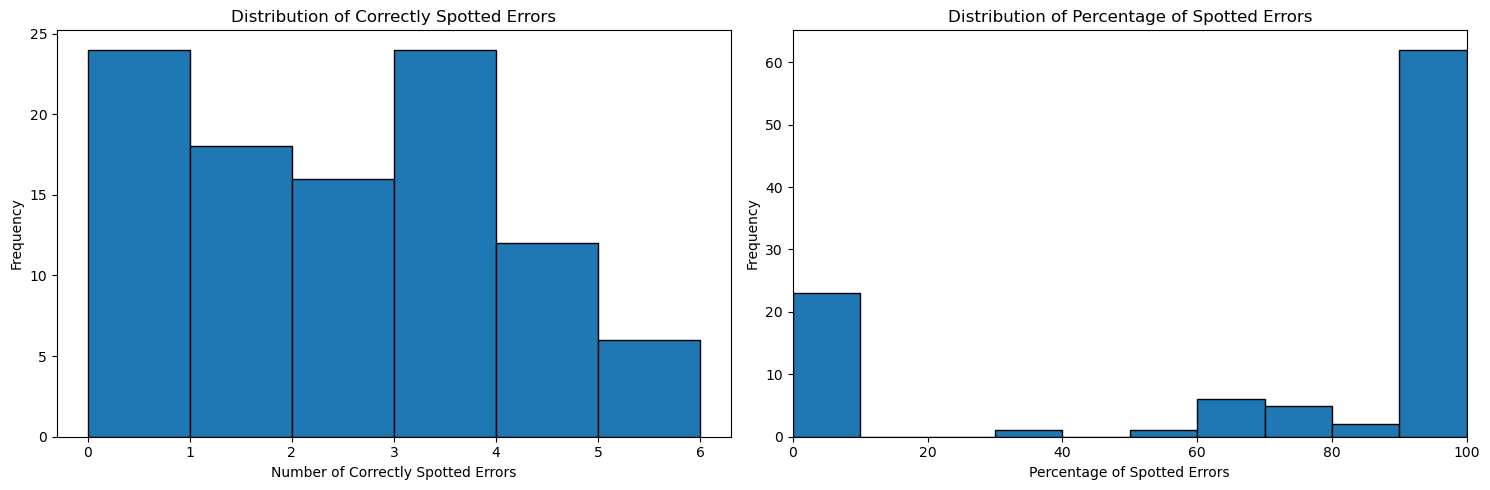

### Additional Statistics:

**Minimum percentage spotted:** 0.00%

**Maximum percentage spotted:** 100.00%

**Median percentage spotted:** 100.00%

## Results for file: judged_Mixtral_8_22B_biology_evaluation_model_Meta-Llama-3.1-8B-Instruct-Turbo.parquet

**Total samples:** 100

**Samples with corrupted_graph of 200+ characters:** 100

**Mean percentage of spotted errors:** 86.78%

**Standard deviation of percentage of spotted errors:** 22.54%

### Explanation:

On average, 86.78% of the planted errors were correctly spotted in samples with substantial corrupted graphs.

The standard deviation of 22.54% indicates the spread of the data around the mean.

This suggests that in most cases, between 64.24% and 100.00% of errors were spotted.

Note: This analysis only considered 100 out of 100 total samples due to the character limit criteria.

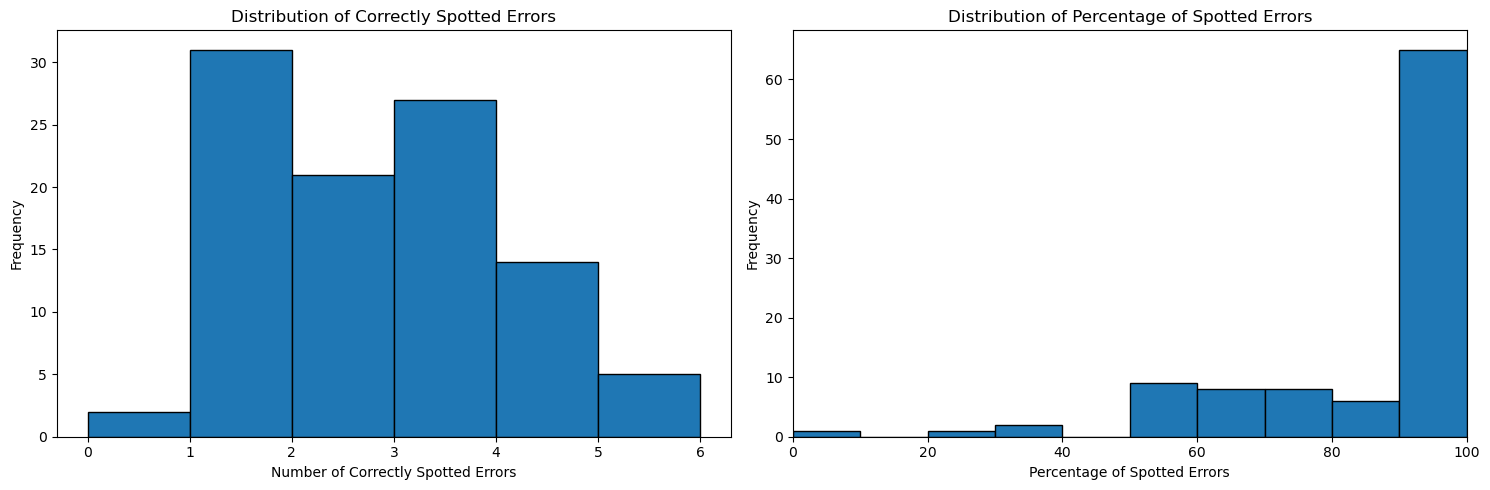

### Additional Statistics:

**Minimum percentage spotted:** 0.00%

**Maximum percentage spotted:** 100.00%

**Median percentage spotted:** 100.00%

## Results for file: judged_Mixtral_8_22B_physics_evaluation_model_Meta-Llama-3.1-70B-Instruct-Turbo.parquet

**Total samples:** 99

**Samples with corrupted_graph of 200+ characters:** 99

**Mean percentage of spotted errors:** 82.83%

**Standard deviation of percentage of spotted errors:** 31.42%

### Explanation:

On average, 82.83% of the planted errors were correctly spotted in samples with substantial corrupted graphs.

The standard deviation of 31.42% indicates the spread of the data around the mean.

This suggests that in most cases, between 51.41% and 100.00% of errors were spotted.

Note: This analysis only considered 99 out of 99 total samples due to the character limit criteria.

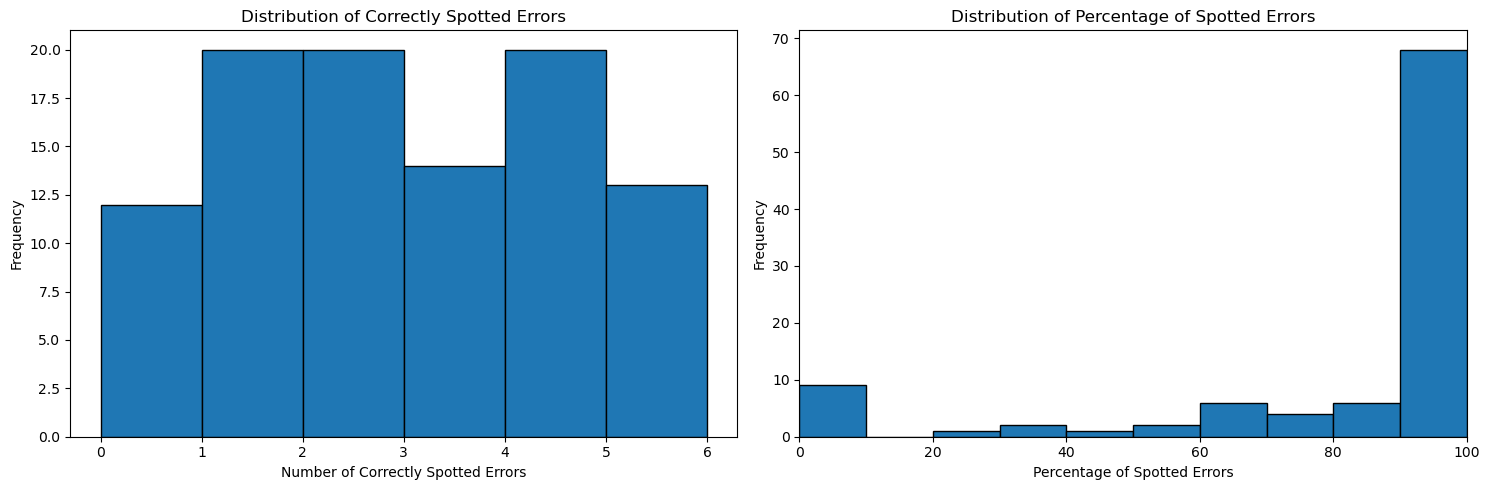

### Additional Statistics:

**Minimum percentage spotted:** 0.00%

**Maximum percentage spotted:** 100.00%

**Median percentage spotted:** 100.00%

## Results for file: judged_Mixtral_8_22B_physics_evaluation_model_Meta-Llama-3.1-8B-Instruct-Turbo.parquet

**Total samples:** 99

**Samples with corrupted_graph of 200+ characters:** 99

**Mean percentage of spotted errors:** 79.04%

**Standard deviation of percentage of spotted errors:** 30.95%

### Explanation:

On average, 79.04% of the planted errors were correctly spotted in samples with substantial corrupted graphs.

The standard deviation of 30.95% indicates the spread of the data around the mean.

This suggests that in most cases, between 48.09% and 100.00% of errors were spotted.

Note: This analysis only considered 99 out of 99 total samples due to the character limit criteria.

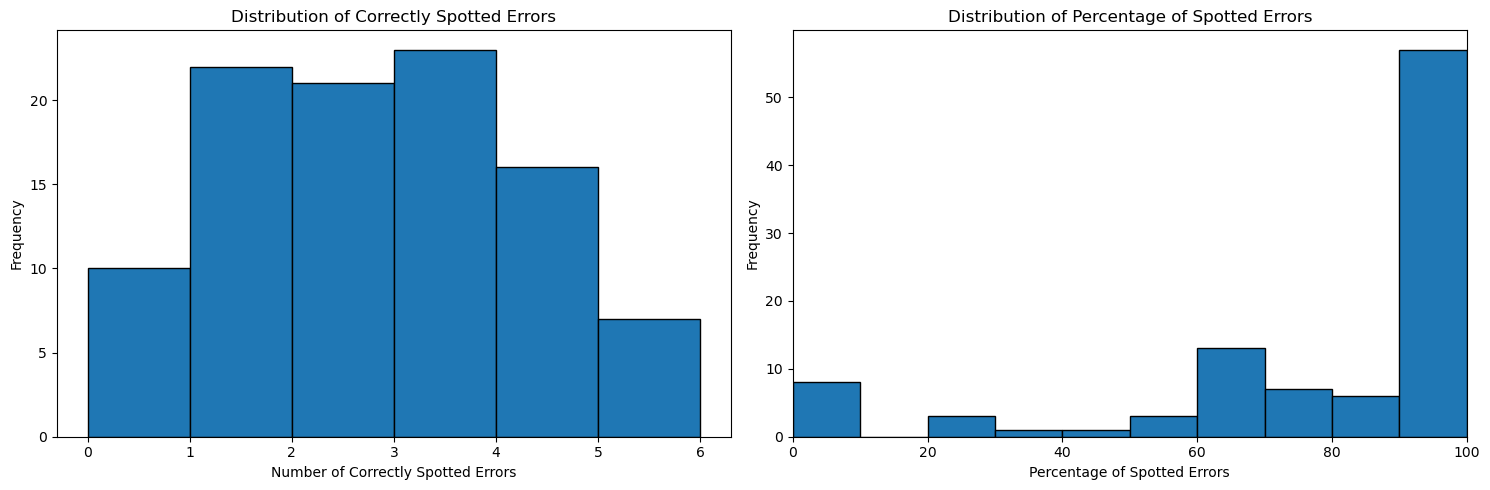

### Additional Statistics:

**Minimum percentage spotted:** 0.00%

**Maximum percentage spotted:** 100.00%

**Median percentage spotted:** 100.00%

**File Mixtral_8_22B_biology.parquet is missing the following required columns:** correctly_spotted_errors, percentage_spotted

**File Mixtral_8_22B_biology_evaluation_model_Meta-Llama-3.1-70B-Instruct-Turbo.parquet is missing the following required columns:** correctly_spotted_errors, percentage_spotted

**File Mixtral_8_22B_biology_evaluation_model_Meta-Llama-3.1-8B-Instruct-Turbo.parquet is missing the following required columns:** correctly_spotted_errors, percentage_spotted

**File Mixtral_8_22B_physics.parquet is missing the following required columns:** correctly_spotted_errors, percentage_spotted

**File Mixtral_8_22B_physics_evaluation_model_Meta-Llama-3.1-70B-Instruct-Turbo.parquet is missing the following required columns:** correctly_spotted_errors, percentage_spotted

**File Mixtral_8_22B_physics_evaluation_model_Meta-Llama-3.1-8B-Instruct-Turbo.parquet is missing the following required columns:** correctly_spotted_errors, percentage_spotted

**File processed_dataset.parquet is missing the following required columns:** correctly_spotted_errors, percentage_spotted

## Results for file: updated_evaluated_Mixtral_8_22B_biology_evaluator_31_405b_Judge_31_70B.parquet

**Total samples:** 100

**Samples with corrupted_graph of 200+ characters:** 100

**Mean percentage of spotted errors:** 94.98%

**Standard deviation of percentage of spotted errors:** 14.83%

### Explanation:

On average, 94.98% of the planted errors were correctly spotted in samples with substantial corrupted graphs.

The standard deviation of 14.83% indicates the spread of the data around the mean.

This suggests that in most cases, between 80.16% and 100.00% of errors were spotted.

Note: This analysis only considered 100 out of 100 total samples due to the character limit criteria.

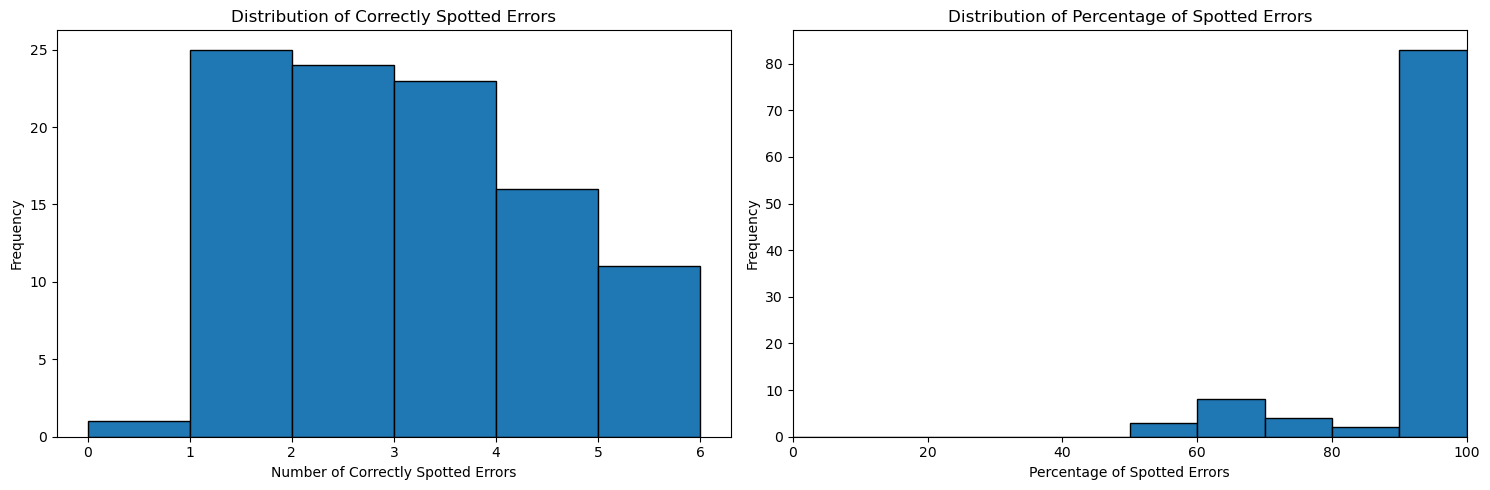

### Additional Statistics:

**Minimum percentage spotted:** 50.00%

**Maximum percentage spotted:** 100.00%

**Median percentage spotted:** 100.00%

## Results for file: updated_evaluated_Mixtral_8_22B_physics_evaluator_31_405b_Judge_31_70B.parquet

**Total samples:** 99

**Samples with corrupted_graph of 200+ characters:** 99

**Mean percentage of spotted errors:** 78.18%

**Standard deviation of percentage of spotted errors:** 36.40%

### Explanation:

On average, 78.18% of the planted errors were correctly spotted in samples with substantial corrupted graphs.

The standard deviation of 36.40% indicates the spread of the data around the mean.

This suggests that in most cases, between 41.78% and 100.00% of errors were spotted.

Note: This analysis only considered 99 out of 99 total samples due to the character limit criteria.

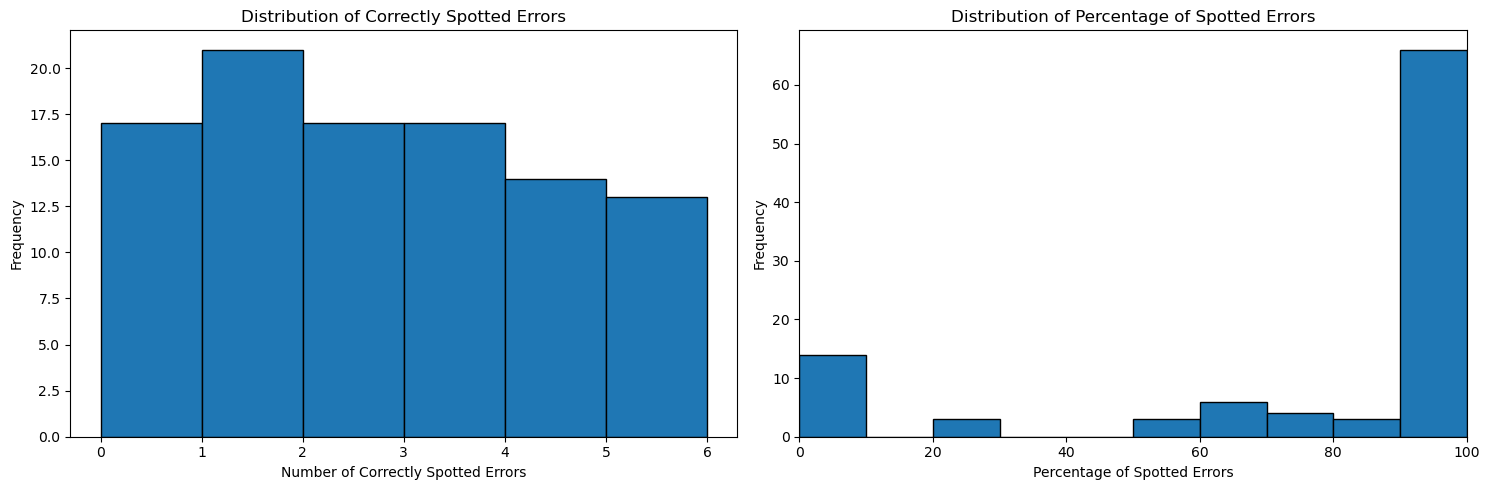

### Additional Statistics:

**Minimum percentage spotted:** 0.00%

**Maximum percentage spotted:** 100.00%

**Median percentage spotted:** 100.00%

Found 2 parquet file(s).


NameError: name 'analyze_parquet_file' is not defined

In [5]:
## VISUALIZE RESULTS
# Visualization and Analysis of Knowledge Graph Error Detection Results

"""
This code implements a visualization and analysis pipeline for the results of knowledge graph 
error detection evaluations. It processes Parquet files containing meta-evaluation results, 
generates statistical summaries, and creates visual representations of the data.

What this code does:
1. Scans for Parquet files in the current directory or uses a predefined list of files.
2. For each file, it reads and analyzes the data, focusing on samples with substantial content.
3. Calculates key statistics about error detection performance.
4. Generates visualizations to represent the distribution of correctly spotted errors and percentages.
5. Displays comprehensive summaries and explanations of the results.

Input:
- Parquet files in the current directory or a predefined list of file paths.
  These files should contain columns:
  a. 'correctly_spotted_errors': Number of errors correctly identified
  b. 'percentage_spotted': Percentage of planted errors that were correctly spotted
  c. 'corrupted_graph': The knowledge graph with planted errors

Output:
For each input file:
- Markdown-formatted summaries displayed in the notebook, including:
  a. Total number of samples and samples meeting analysis criteria
  b. Mean and standard deviation of percentage of spotted errors
  c. Explanation of results and their implications
  d. Additional statistics (min, max, median of percentage spotted)
- Visualizations:
  a. Histogram of correctly spotted errors
  b. Histogram of percentage of spotted errors
- Console output summarizing the files found and processed

Key components:
- analyze_and_plot_parquet_file(): Main function for processing each Parquet file.
  It performs data analysis, generates statistics, and creates visualizations.

Workflow:
1. The script identifies Parquet files to process.
2. For each file:
   a. It reads the Parquet file into a dataframe.
   b. Filters samples based on the length of the corrupted graph.
   c. Calculates statistical measures (mean, standard deviation, etc.).
   d. Generates and displays comprehensive Markdown summaries.
   e. Creates and displays histograms for error detection metrics.
   f. Provides additional statistical insights.

Note: This code is designed to work in a Jupyter Notebook environment, 
utilizing IPython.display for rich output. It provides a comprehensive 
overview of the error detection performance, aiding in the assessment 
and improvement of knowledge graph evaluation models.
"""


import os
import pandas as pd
import numpy as np

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

def analyze_and_plot_parquet_file(file_path):
    # Read the parquet file
    df = pd.read_parquet(file_path)
    
    # Check if required columns are present
    required_columns = ["correctly_spotted_errors", "percentage_spotted", "corrupted_graph"]
    if all(col in df.columns for col in required_columns):
        # Filter samples where corrupted_graph has at least 200 characters
        df_filtered = df[df["corrupted_graph"].str.len() >= 200]
        
        if df_filtered.empty:
            display(Markdown(f"**File {file_path} does not contain any samples with corrupted_graph of 200+ characters.**"))
            return

        # Calculate mean and standard deviation
        mean_percentage = df_filtered["percentage_spotted"].mean()
        std_percentage = df_filtered["percentage_spotted"].std()
        
        display(Markdown(f"## Results for file: {file_path}"))
        display(Markdown(f"**Total samples:** {len(df)}"))
        display(Markdown(f"**Samples with corrupted_graph of 200+ characters:** {len(df_filtered)}"))
        display(Markdown(f"**Mean percentage of spotted errors:** {mean_percentage:.2f}%"))
        display(Markdown(f"**Standard deviation of percentage of spotted errors:** {std_percentage:.2f}%"))
        
        display(Markdown("### Explanation:"))
        display(Markdown(f"On average, {mean_percentage:.2f}% of the planted errors were correctly spotted in samples with substantial corrupted graphs."))
        display(Markdown(f"The standard deviation of {std_percentage:.2f}% indicates the spread of the data around the mean."))
        display(Markdown(f"This suggests that in most cases, between {max(0, mean_percentage - std_percentage):.2f}% and {min(100, mean_percentage + std_percentage):.2f}% of errors were spotted."))
        display(Markdown(f"Note: This analysis only considered {len(df_filtered)} out of {len(df)} total samples due to the character limit criteria."))
        
        # Create histograms
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Histogram for correctly spotted errors
        ax1.hist(df_filtered["correctly_spotted_errors"], bins=range(0, df_filtered["correctly_spotted_errors"].max()+2, 1), edgecolor='black')
        ax1.set_title("Distribution of Correctly Spotted Errors")
        ax1.set_xlabel("Number of Correctly Spotted Errors")
        ax1.set_ylabel("Frequency")
        
        # Histogram for percentage spotted (fixed)
        percentage_data = df_filtered["percentage_spotted"].clip(0, 100)  # Clip values to 0-100 range
        bins = range(0, 101, 10)  # Create bins from 0 to 100, with 10% intervals
        ax2.hist(percentage_data, bins=bins, edgecolor='black')
        ax2.set_title("Distribution of Percentage of Spotted Errors")
        ax2.set_xlabel("Percentage of Spotted Errors")
        ax2.set_ylabel("Frequency")
        ax2.set_xlim(0, 100)  # Set x-axis limits from 0 to 100
        
        plt.tight_layout()
        plt.show()
        
        # Additional statistics
        display(Markdown("### Additional Statistics:"))
        display(Markdown(f"**Minimum percentage spotted:** {percentage_data.min():.2f}%"))
        display(Markdown(f"**Maximum percentage spotted:** {percentage_data.max():.2f}%"))
        display(Markdown(f"**Median percentage spotted:** {percentage_data.median():.2f}%"))
        
    else:
        missing_columns = [col for col in required_columns if col not in df.columns]
        display(Markdown(f"**File {file_path} is missing the following required columns:** {', '.join(missing_columns)}"))
# Get all parquet files in the current directory
parquet_files = [f for f in os.listdir() if f.endswith('.parquet')]

if not parquet_files:
    display(Markdown("**No parquet files found in the current directory.**"))
else:
    display(Markdown(f"**Found {len(parquet_files)} parquet file(s).**"))
    
    # Analyze each parquet file
    for file in parquet_files:
        analyze_and_plot_parquet_file(file)
        
# Get all parquet files in the current directory
parquet_files = ["judged_Mixtral_8_22B_biology_evaluation_model_Meta-Llama-3.1-70B-Instruct-Turbo.parquet" , "judged_Mixtral_8_22B_biology_evaluation_model_Meta-Llama-3.1-70B-Instruct-Turbo.parquet"]

if not parquet_files:
    print("No parquet files found in the current directory.")


print(f"Found {len(parquet_files)} parquet file(s).")

# Analyze each parquet file
for file in parquet_files:
    analyze_parquet_file(file)


In [7]:
!pip install -U datasets pyarrow